In [5]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../')

from main import load_and_prepare_sessions
from processing.session_sampling import MiceAnalysis
from data.mouse import create_mice_dict
from plotting.main_plotting import plot_session_events_and_signal
from analysis.timepoint_analysis import sample_signals_and_metrics
from itertools import product

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import scipy.stats as stats
from tqdm.notebook import tqdm
from collections import defaultdict

import config

sessions = load_and_prepare_sessions("../../../trial_Gq-DREADD_CPT", load_from_pickle=True, remove_bad_signal_sessions=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import matplotlib.pyplot as plt
import pickle

In [7]:
all_signal_groups = defaultdict(list)

for session in sessions:
    genotype = session.genotype
    dose = session.drug_info['dose']
    for brain_reg in session.brain_regions:
        phot_df = session.df_container.data['photwrit_470']
        phot_times = phot_df['SecFromZero_FP3002'].values
        raw_df = session.df_container.data['raw']
    
        signal = phot_df[f'{brain_reg}_phot_zF']
        blank_image_time = raw_df.iloc[session.cpt]['SecFromZero_FP3002']
        cpt_start_signal_idx = np.searchsorted(phot_times, blank_image_time, side='left')

        # Extract the desired slice and convert to a numpy array with shape (n, 1)
        signal_array = signal.iloc[cpt_start_signal_idx- 20*60*10:cpt_start_signal_idx+36000].to_numpy()
        curr_key = (genotype, dose, brain_reg)
        all_signal_groups[curr_key].append(signal_array)
        
all_signal_groups = {k: np.stack(v) for k, v in all_signal_groups.items()}

# with open('all_session_averages_1.pkl', 'wb') as file:
#     # Dump the dictionary into the file
#     pickle.dump(all_signal_groups, file)


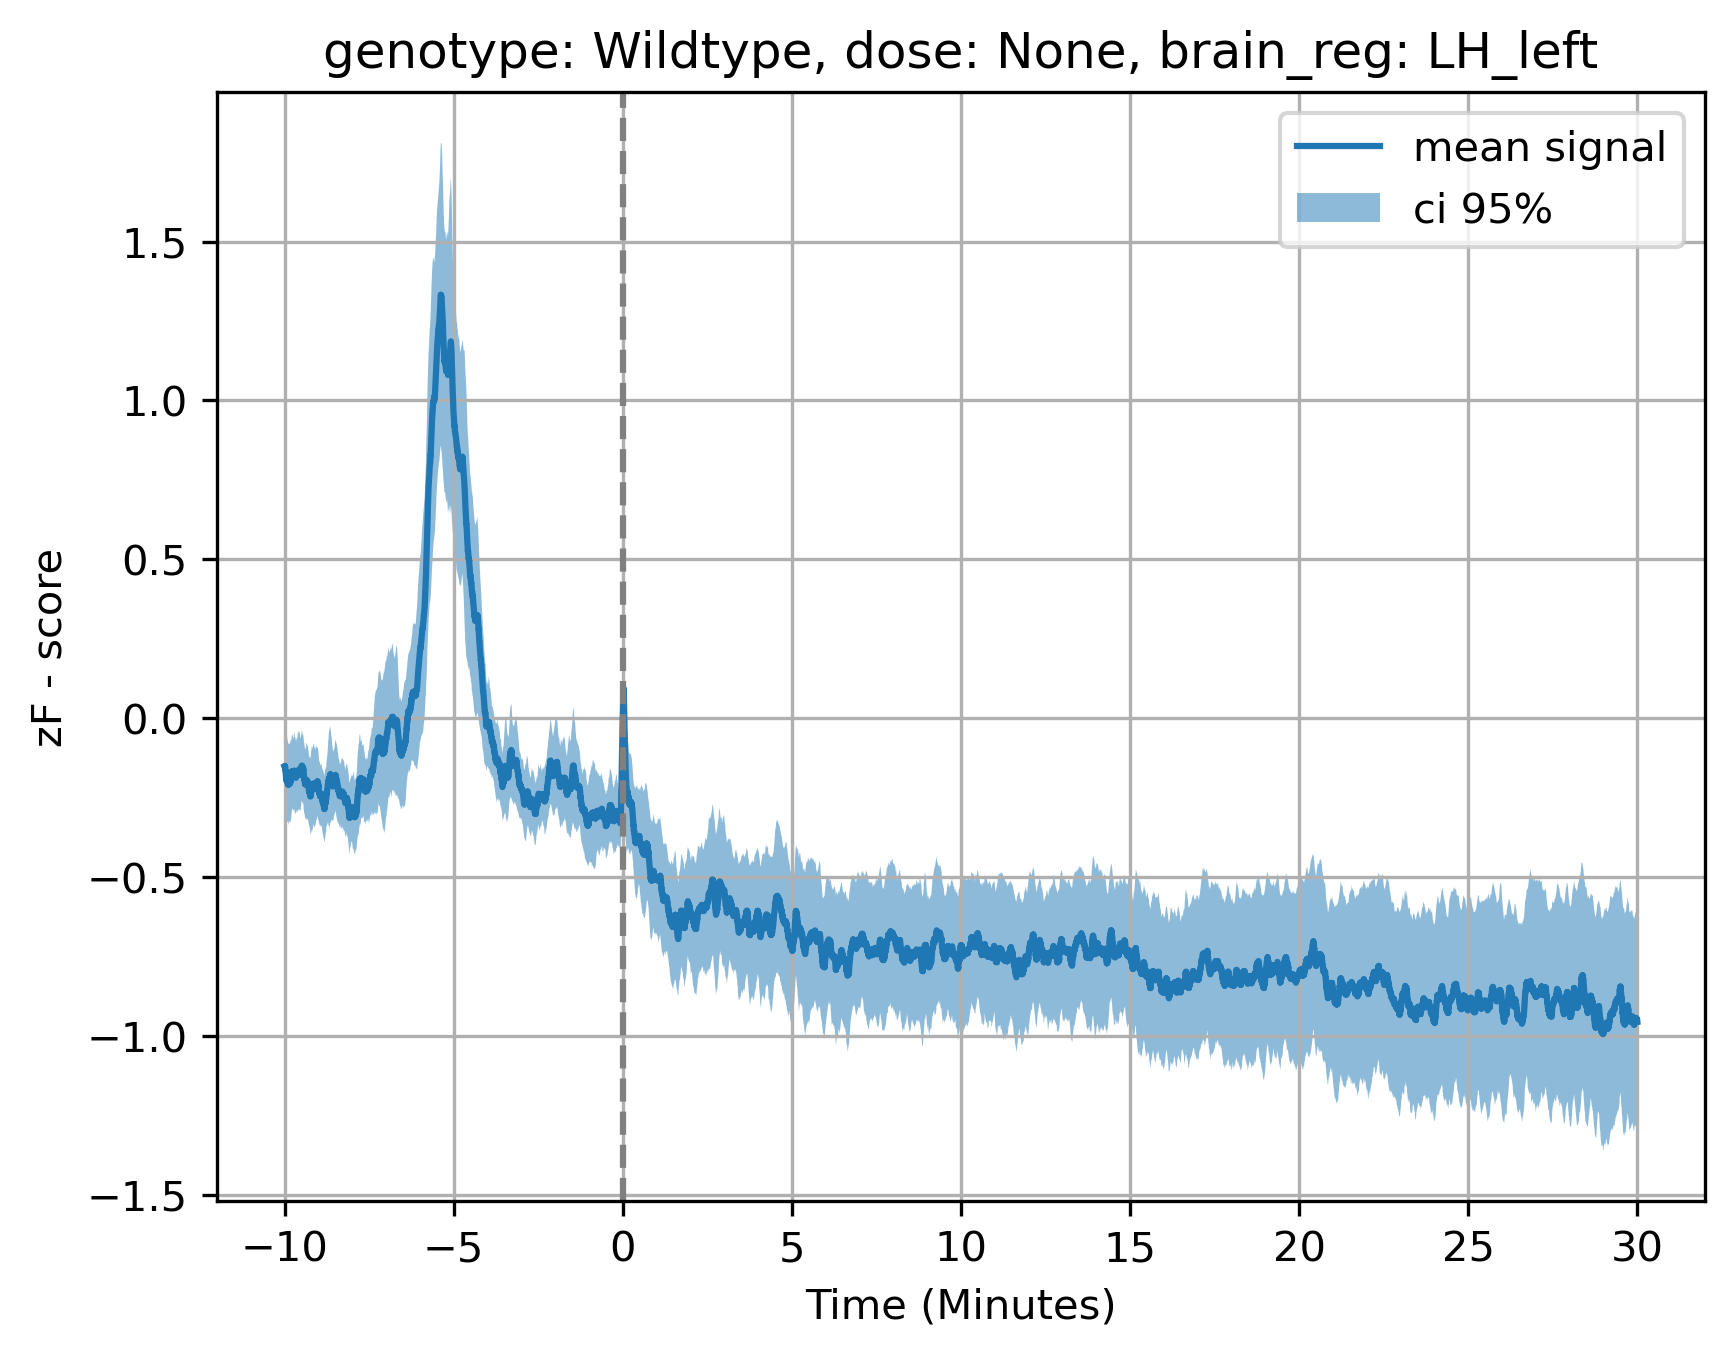

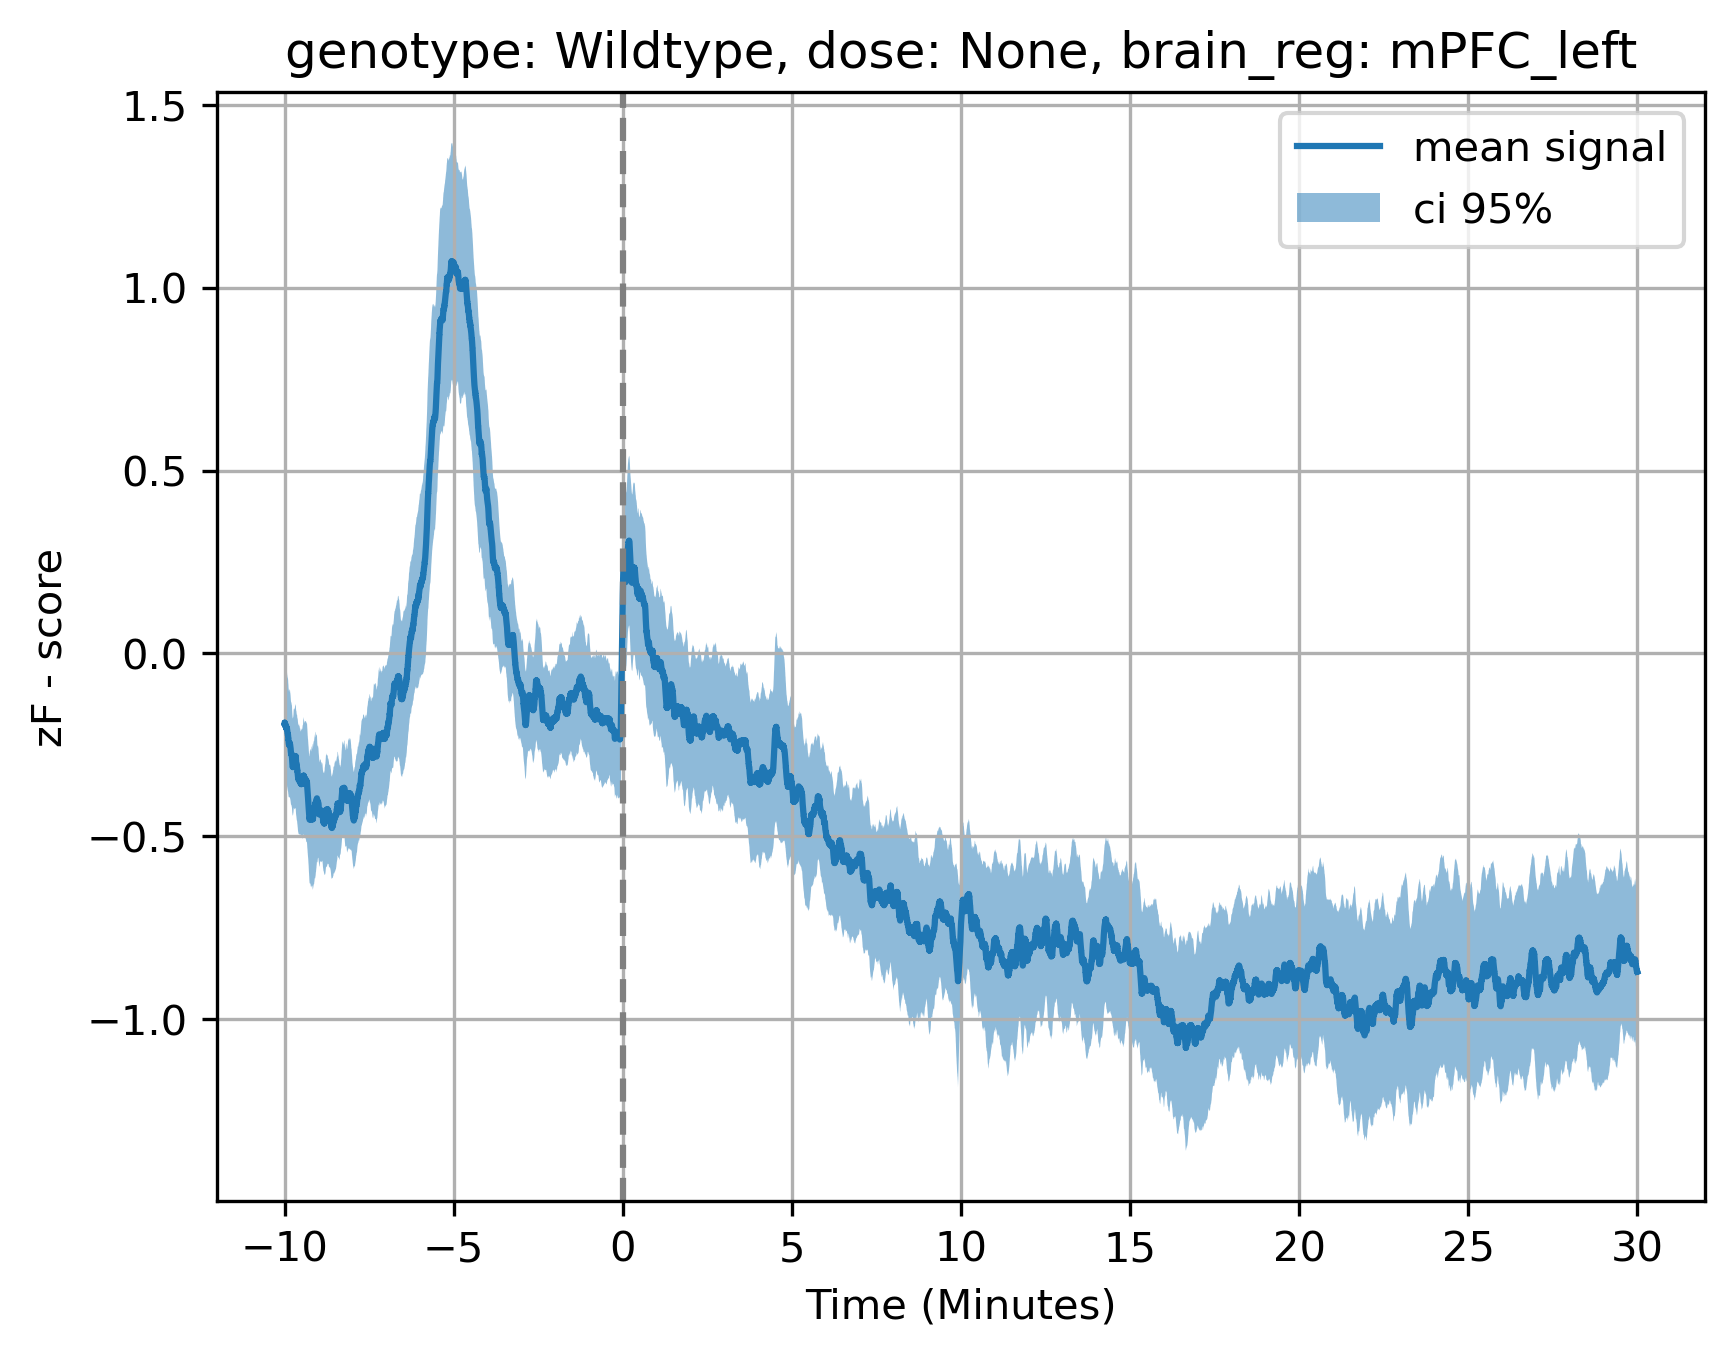

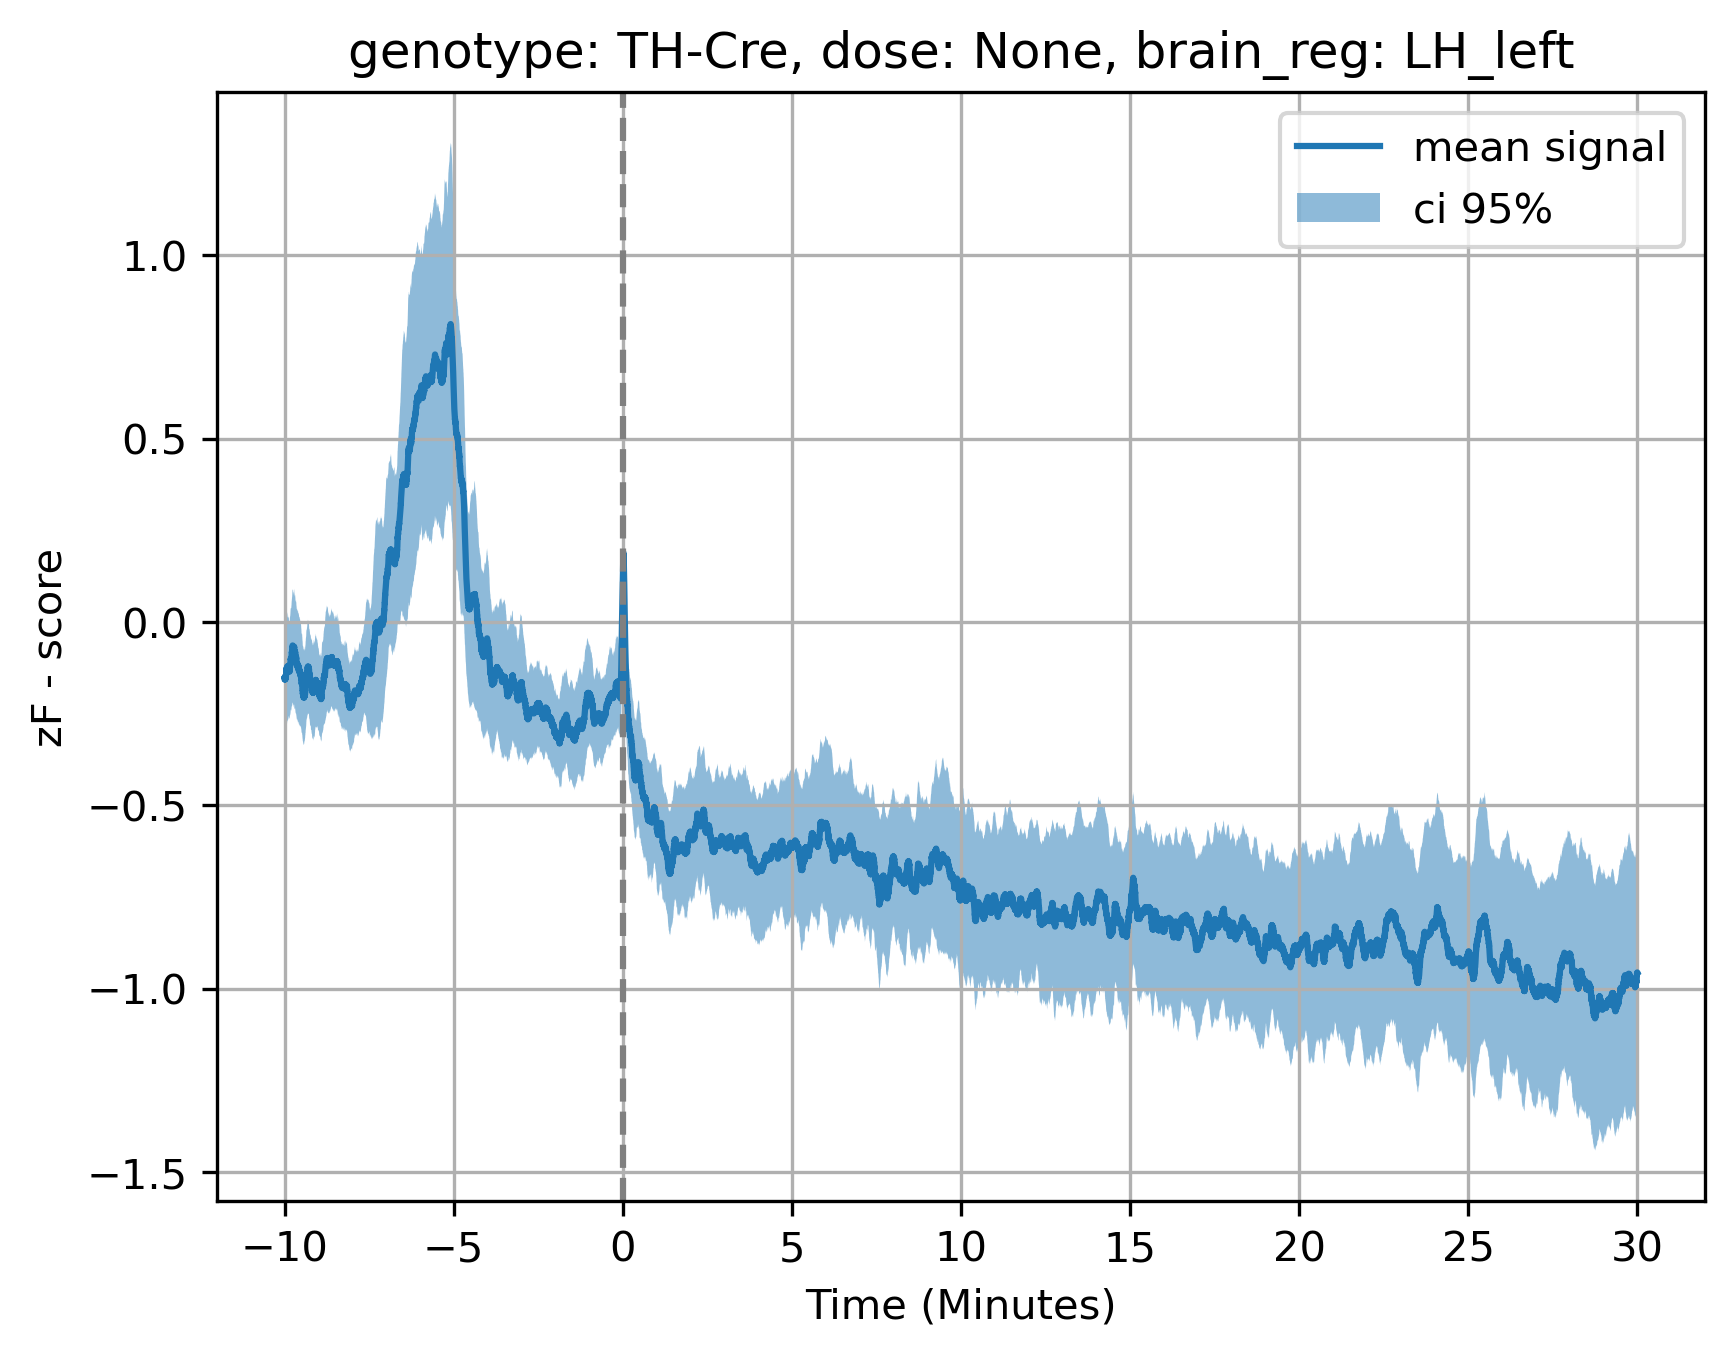

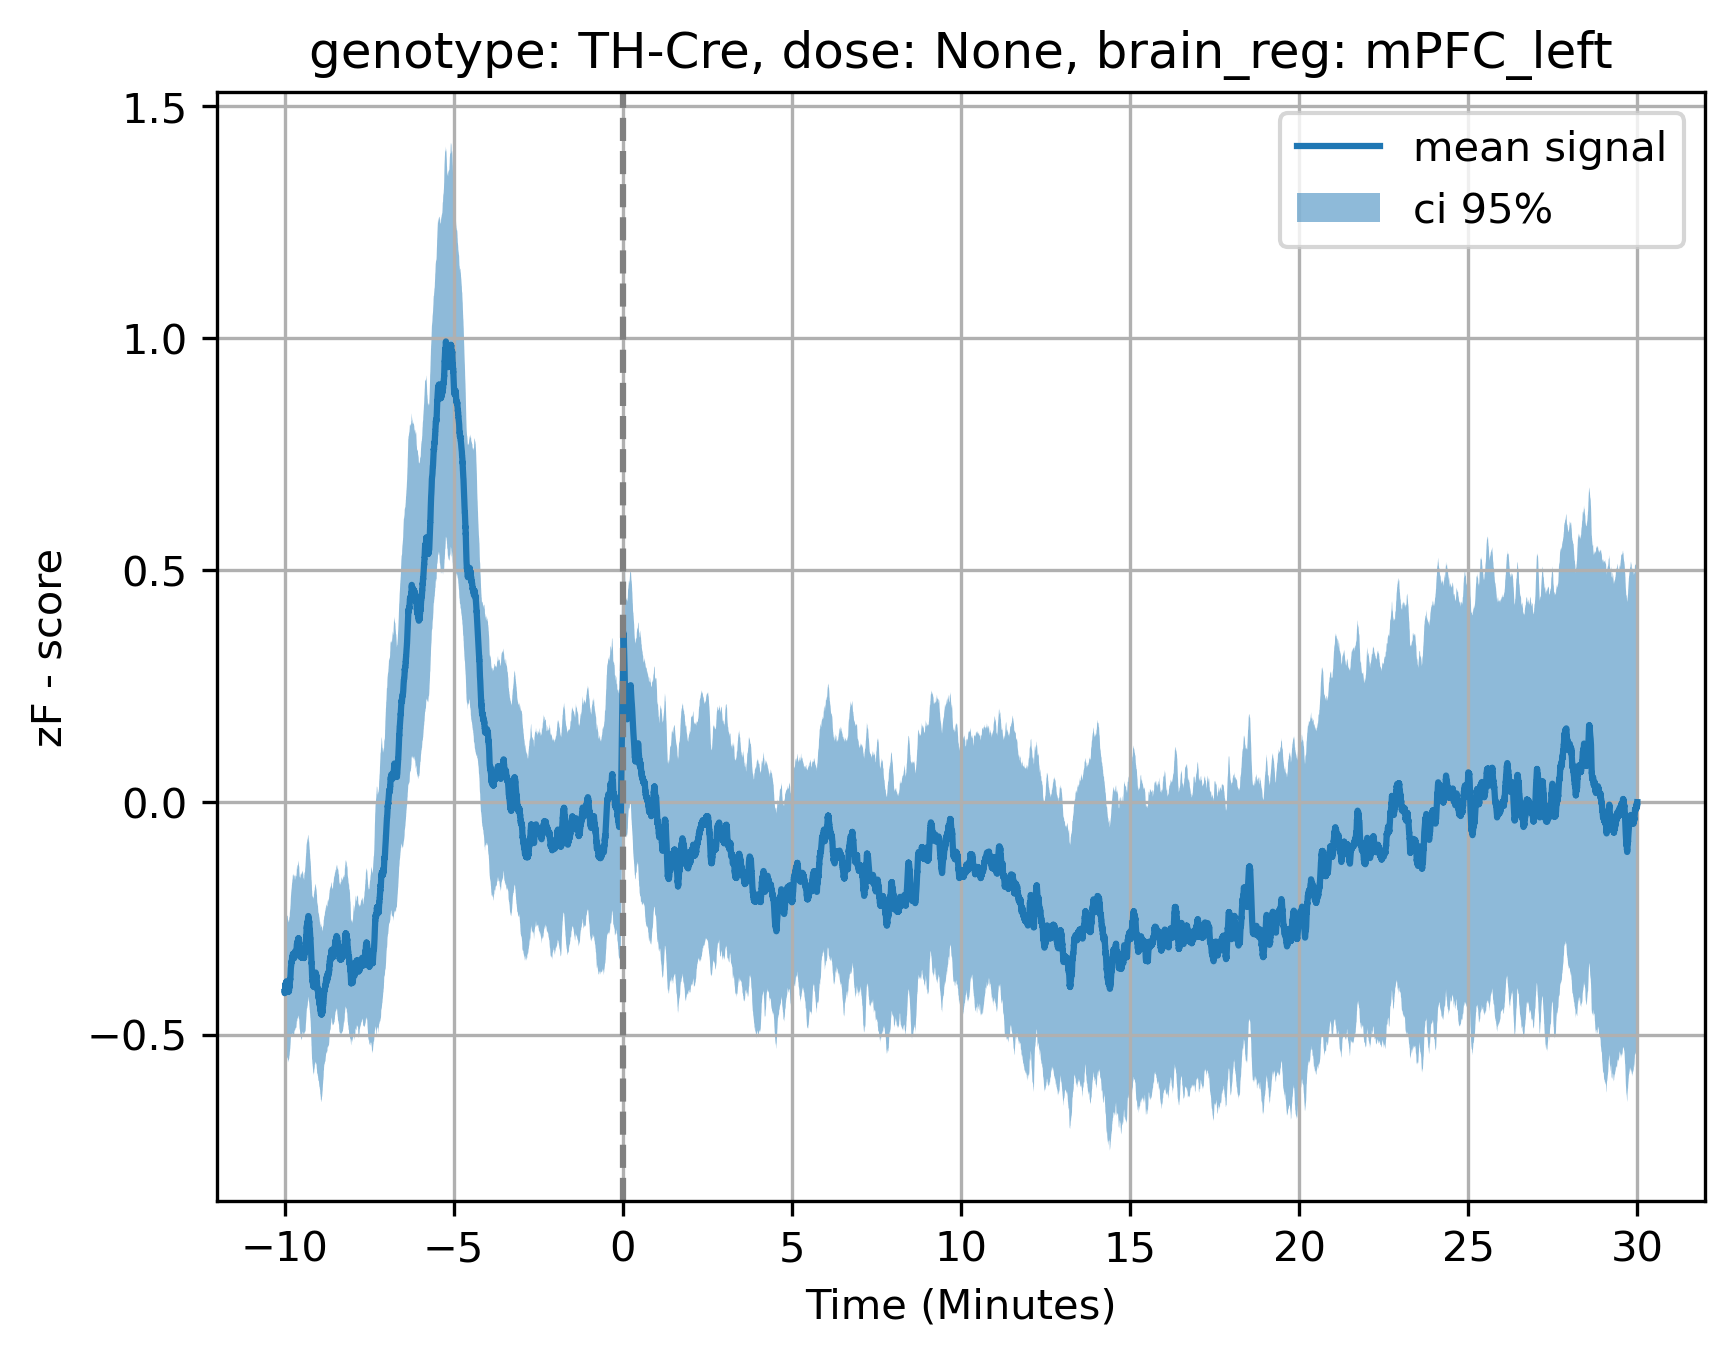

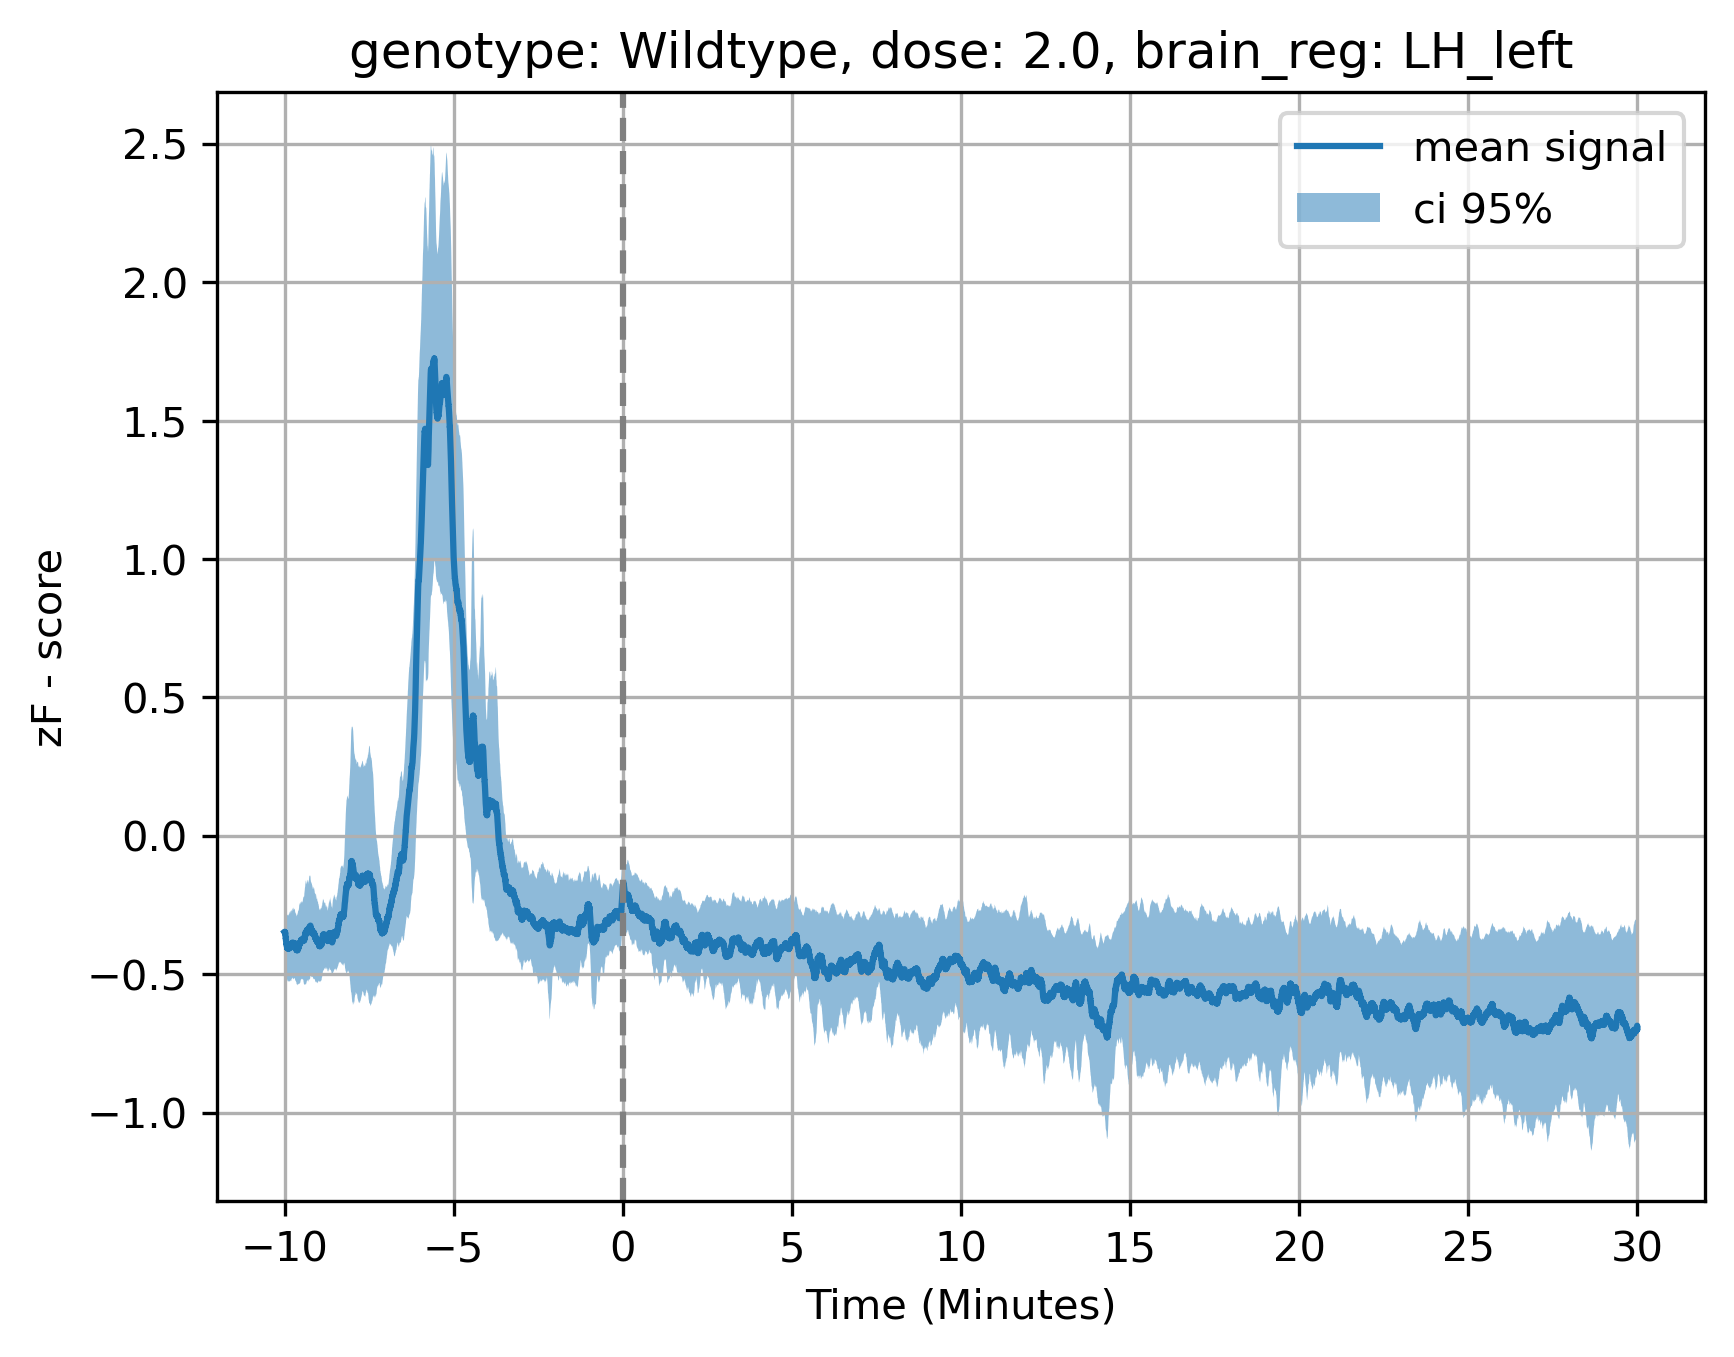

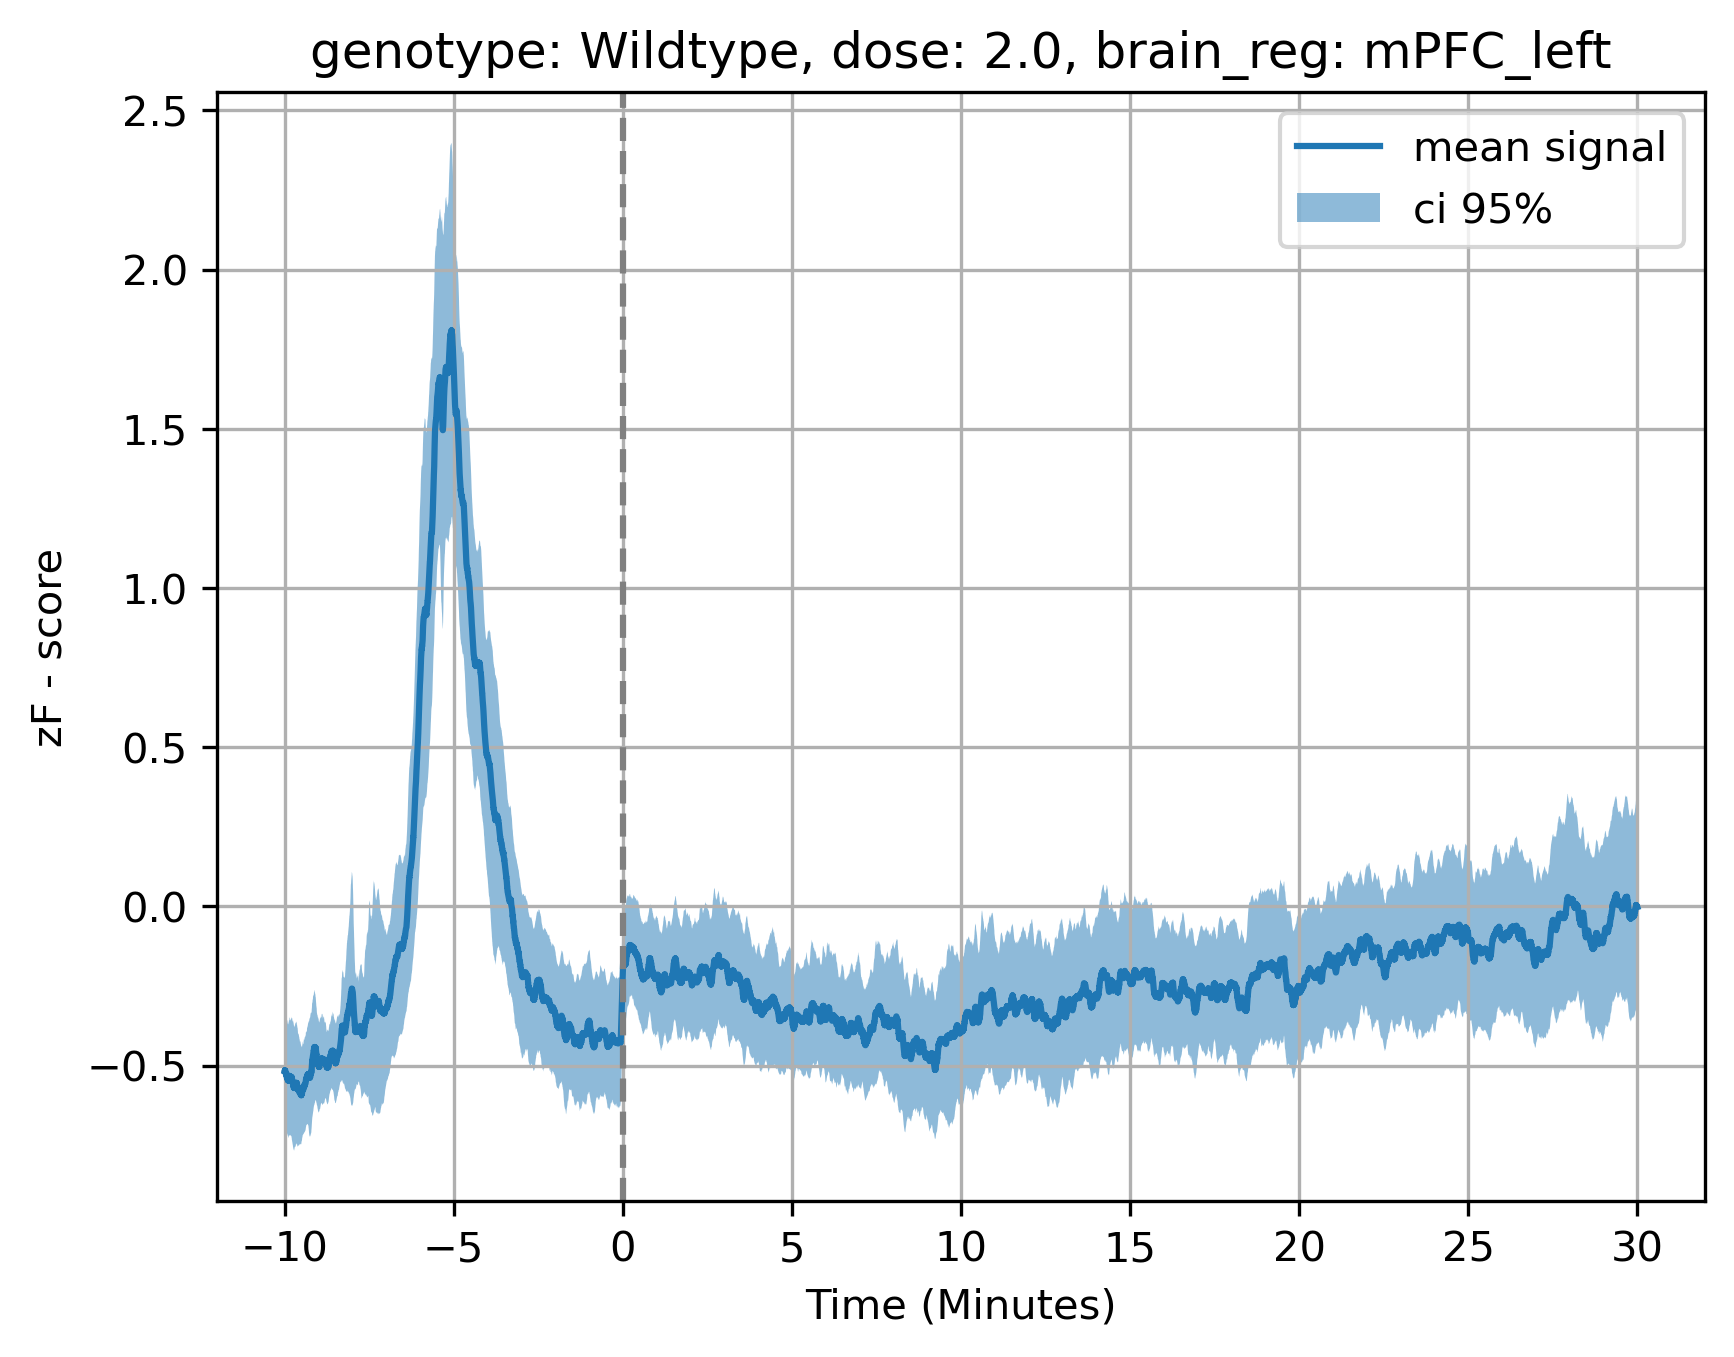

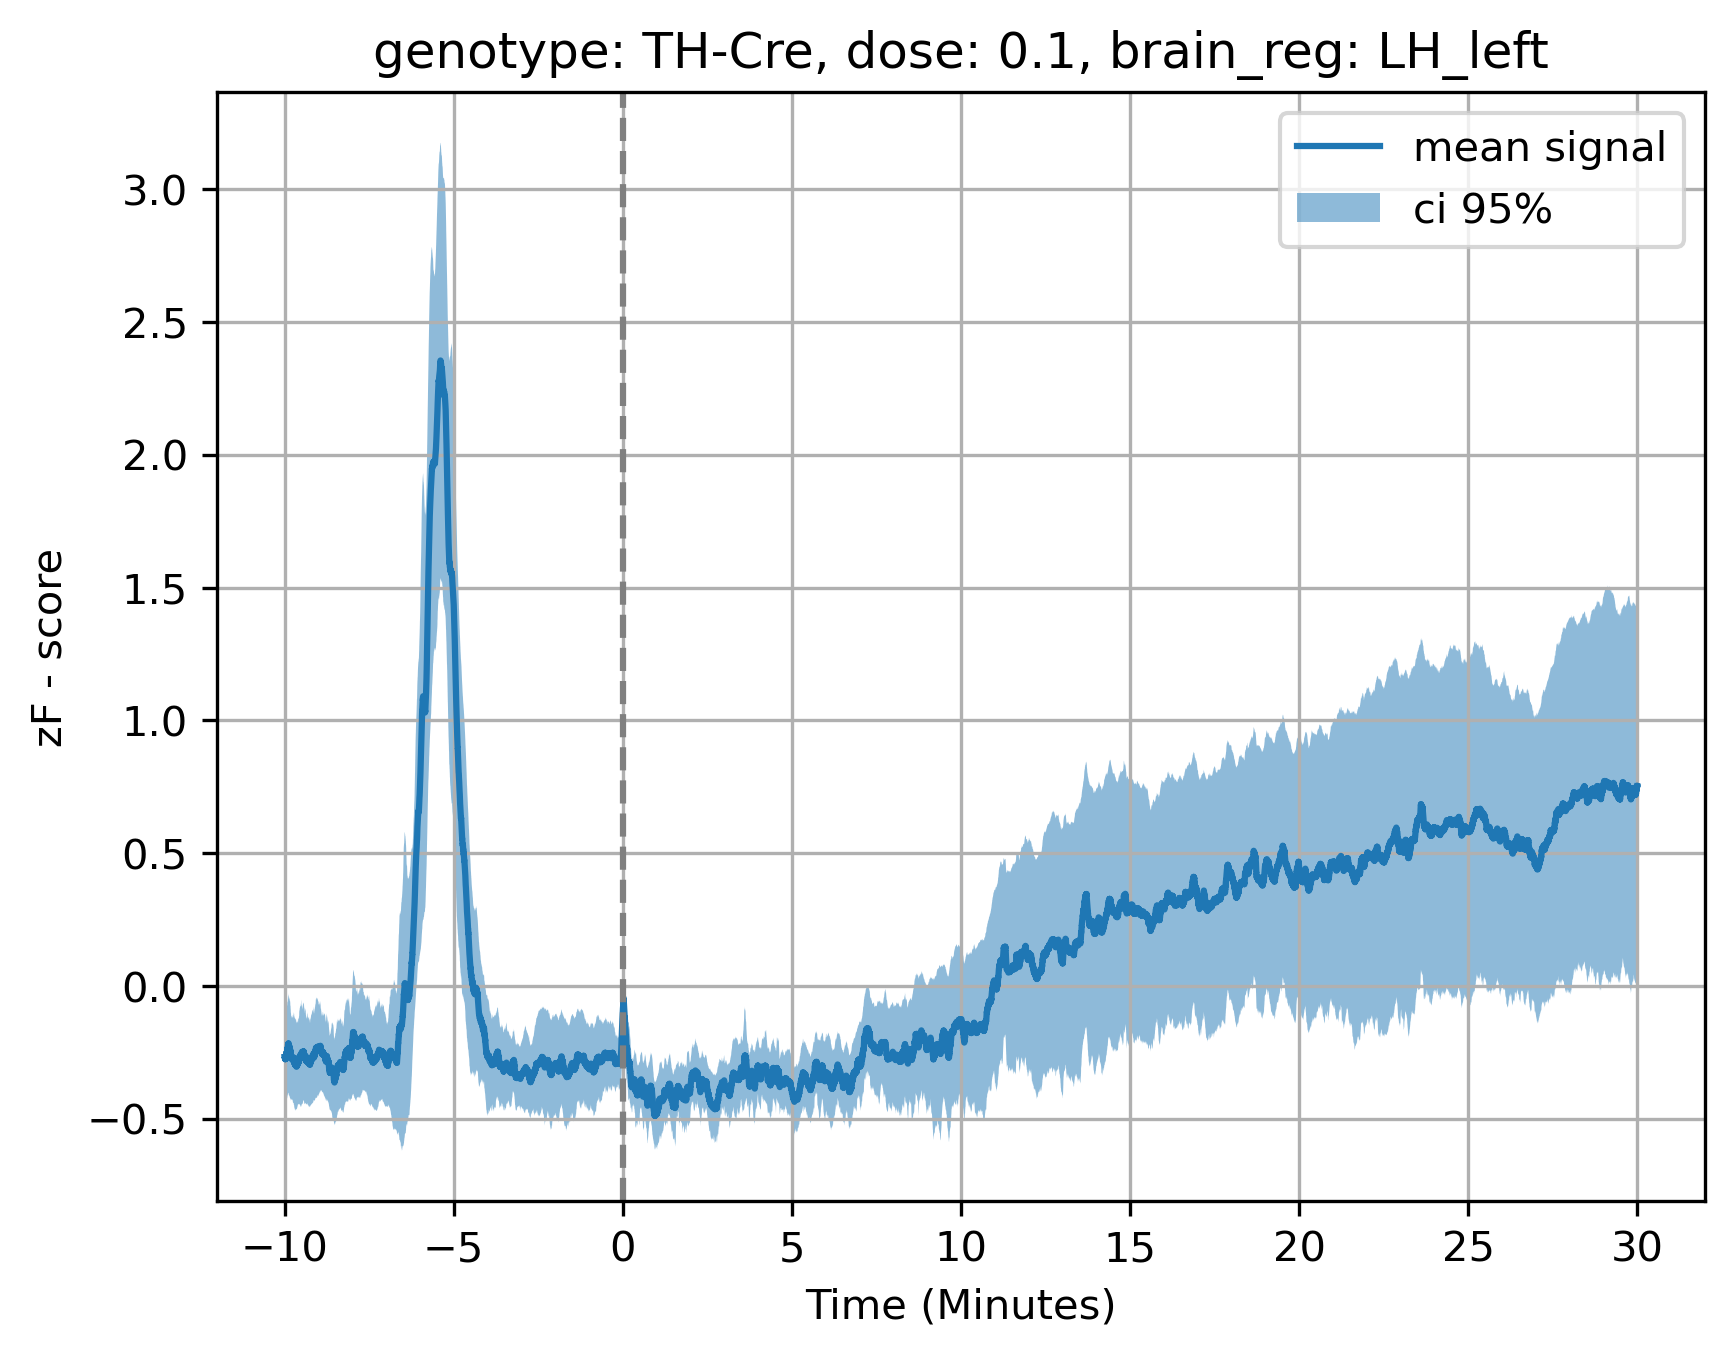

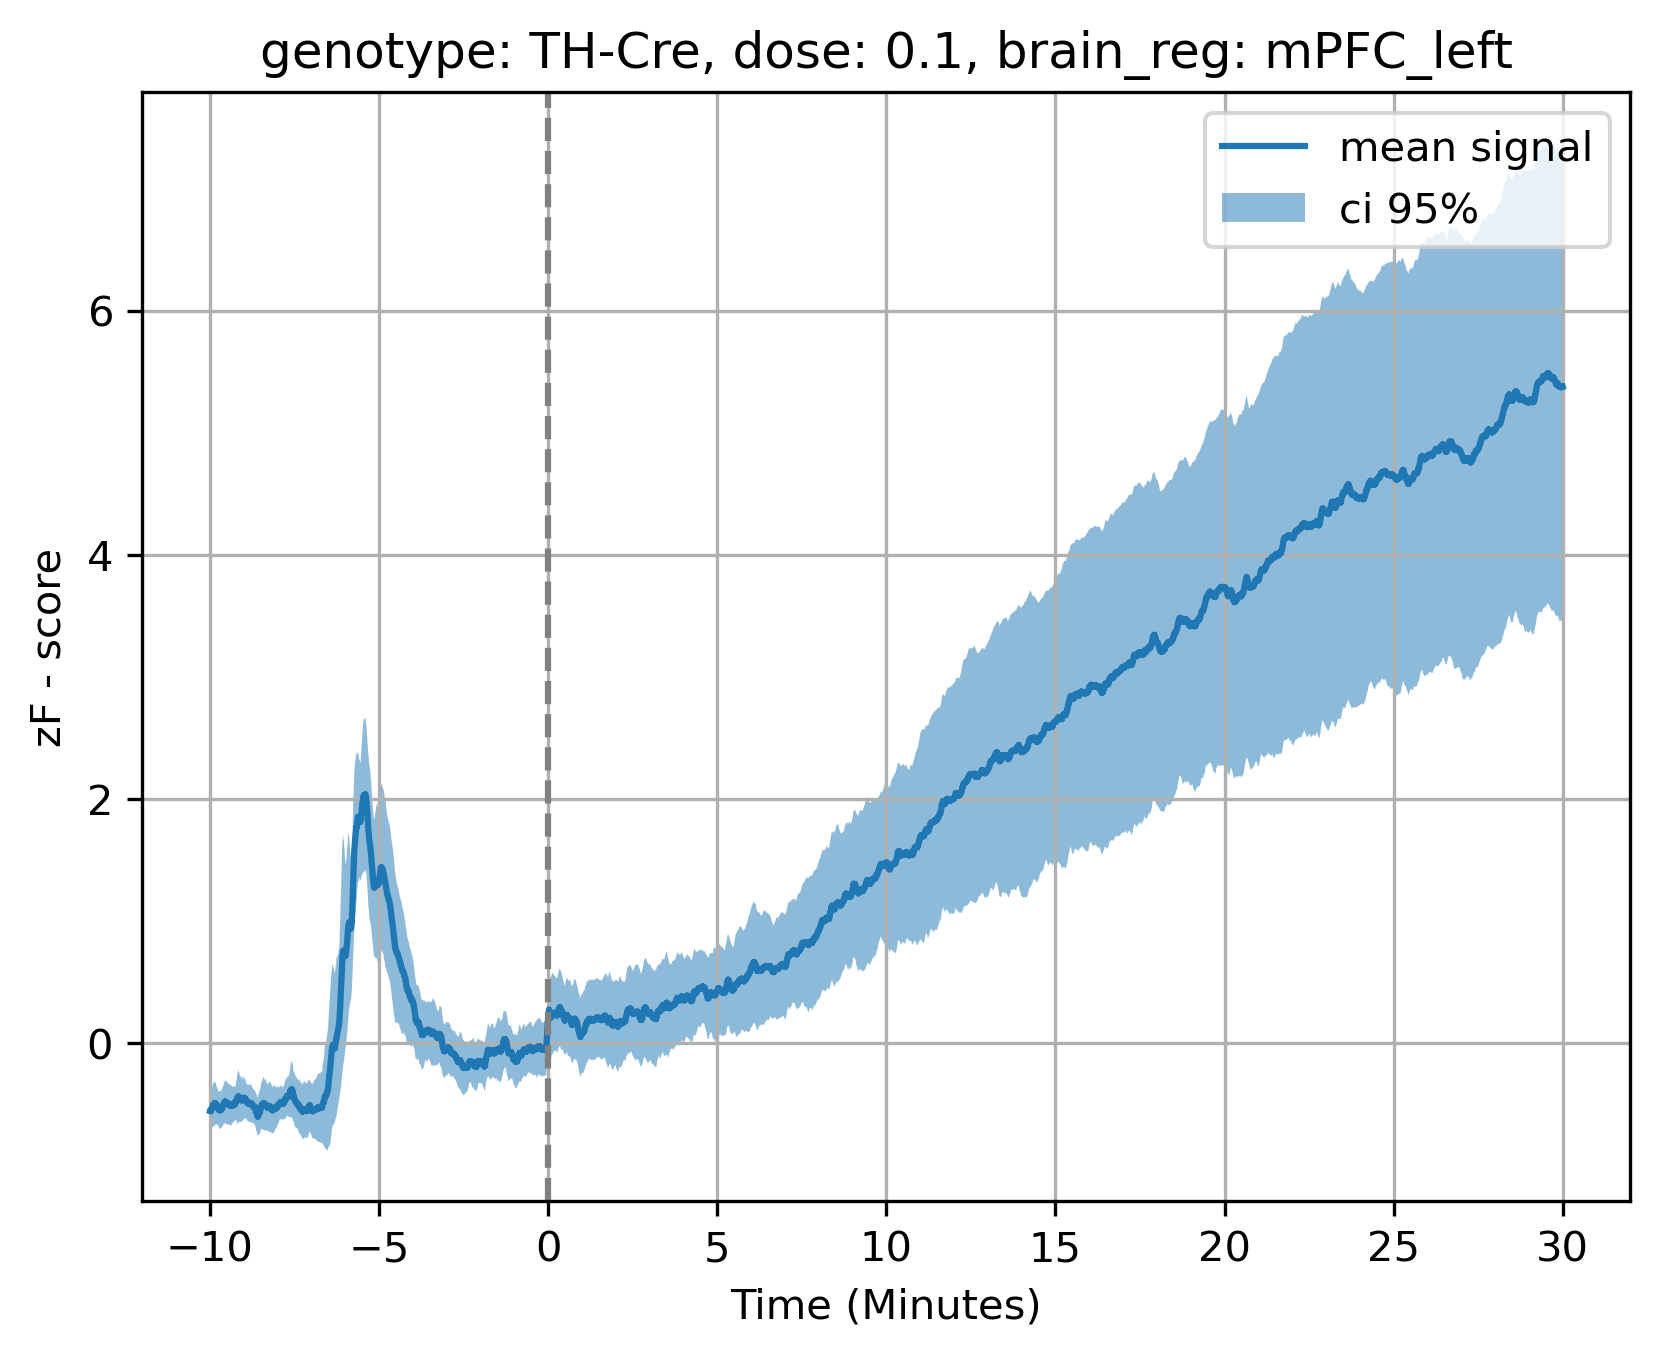

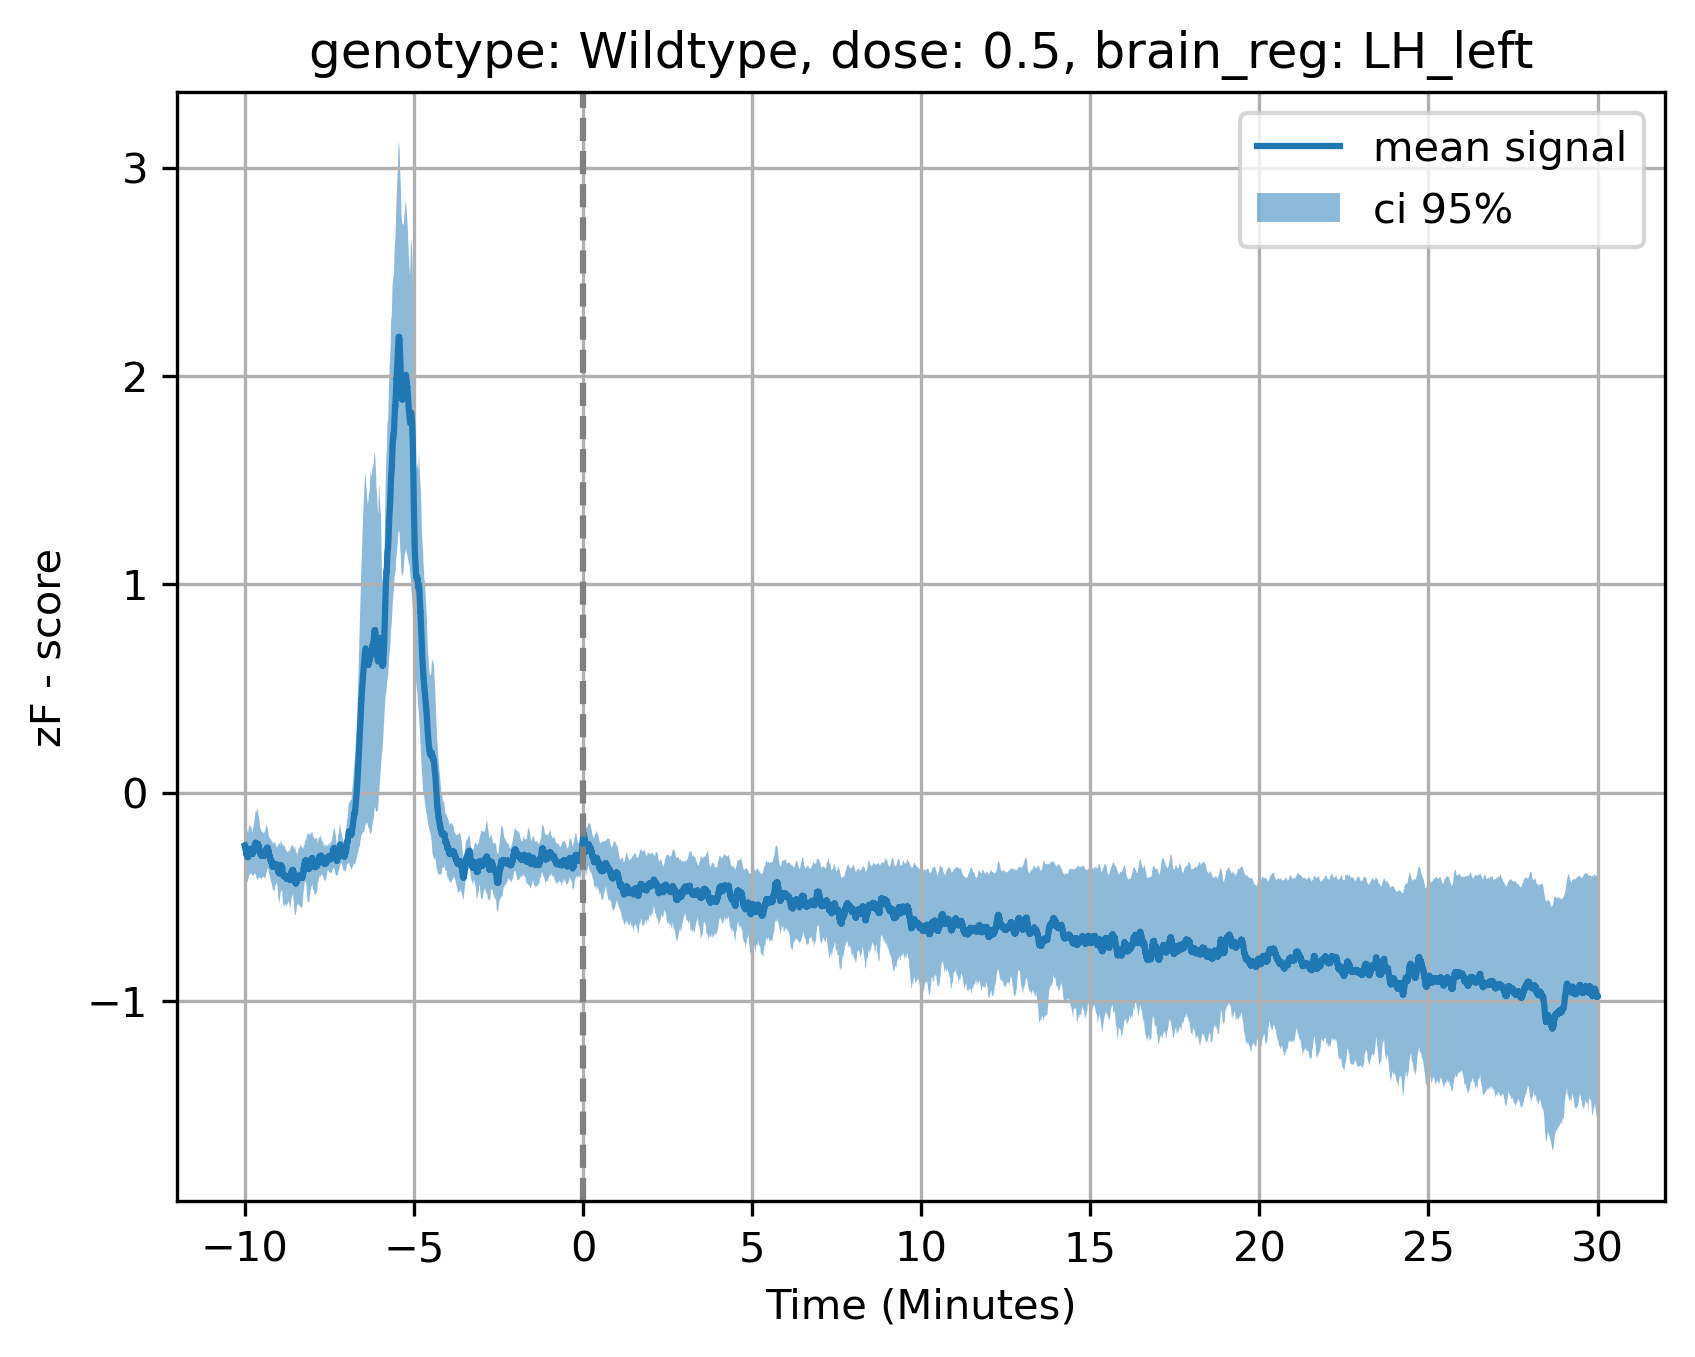

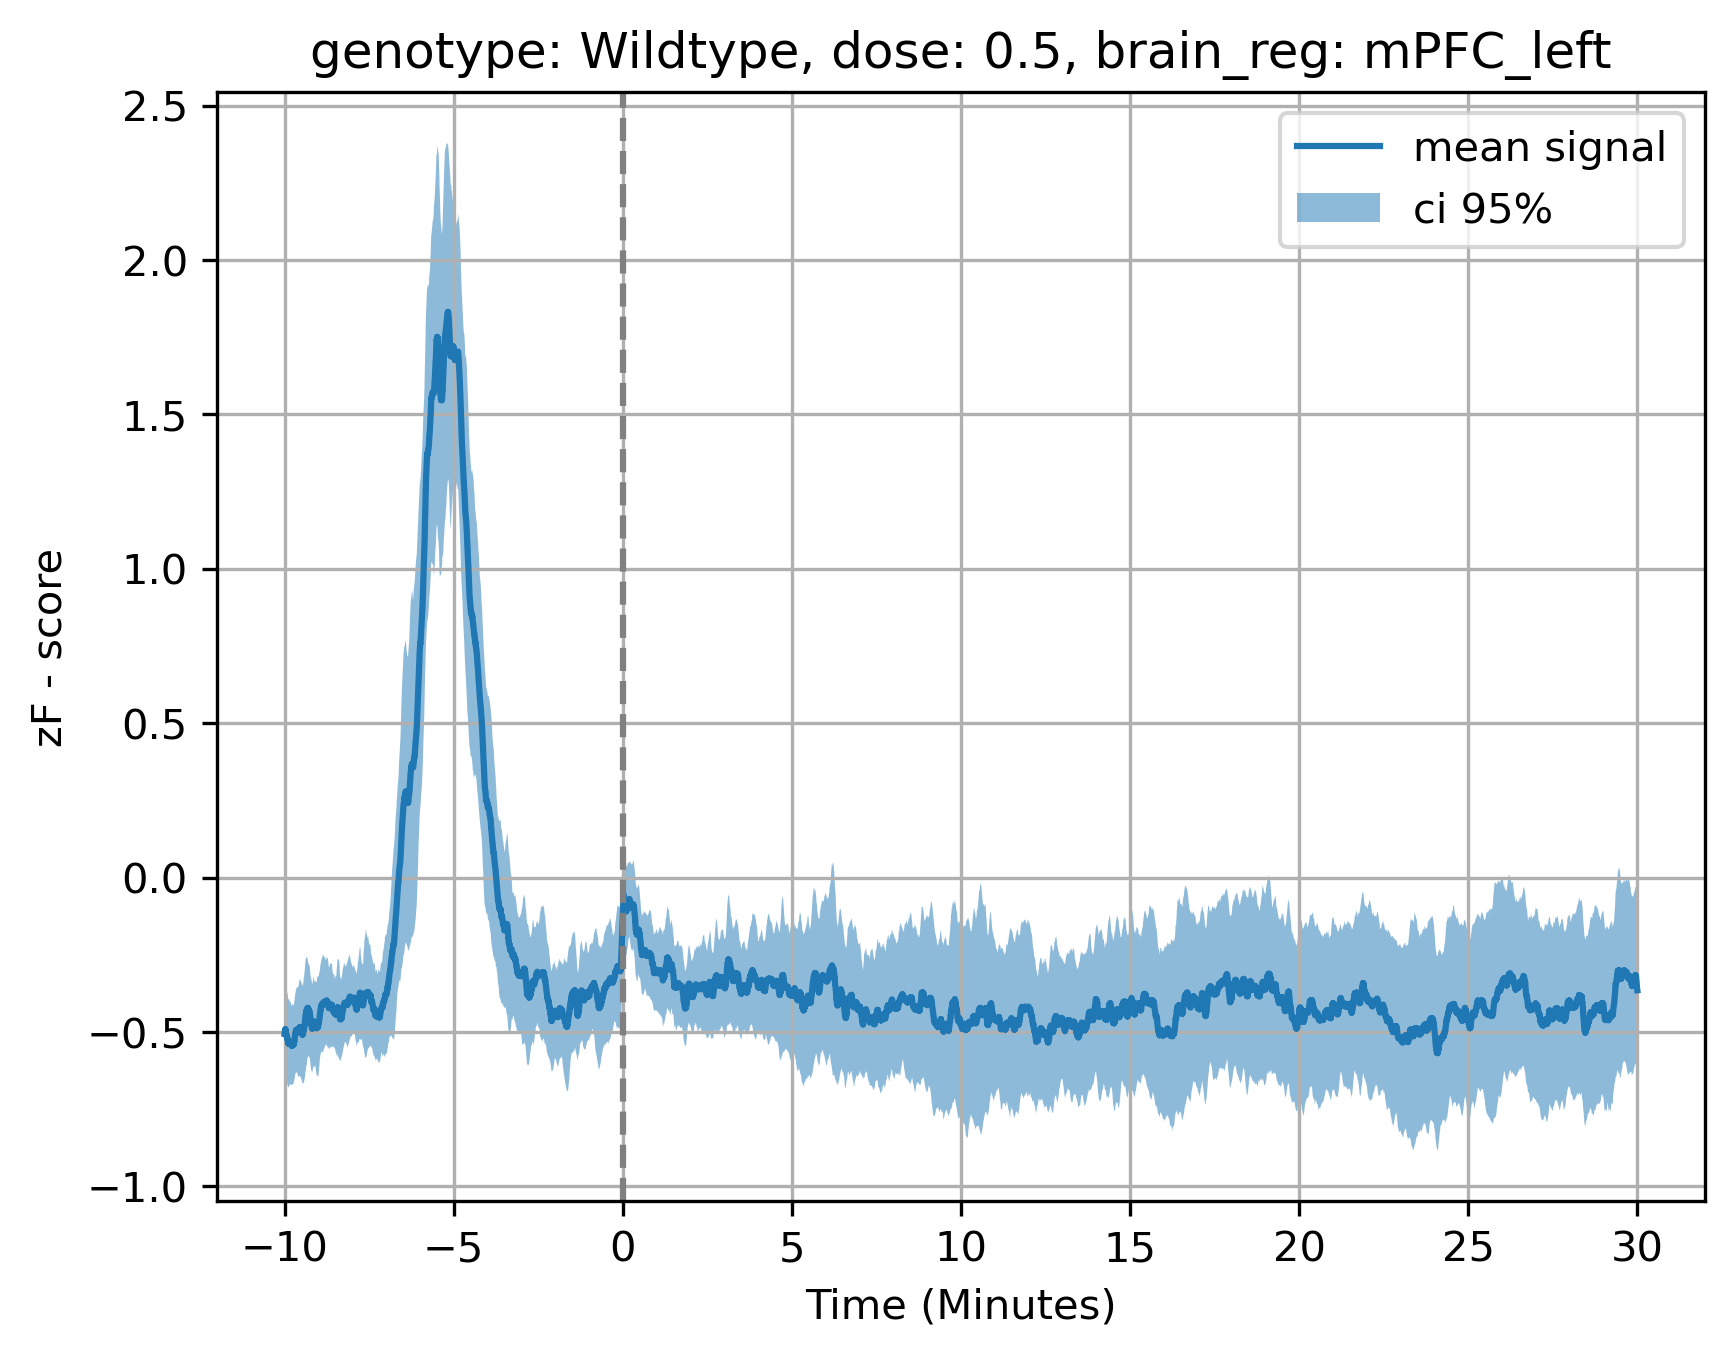

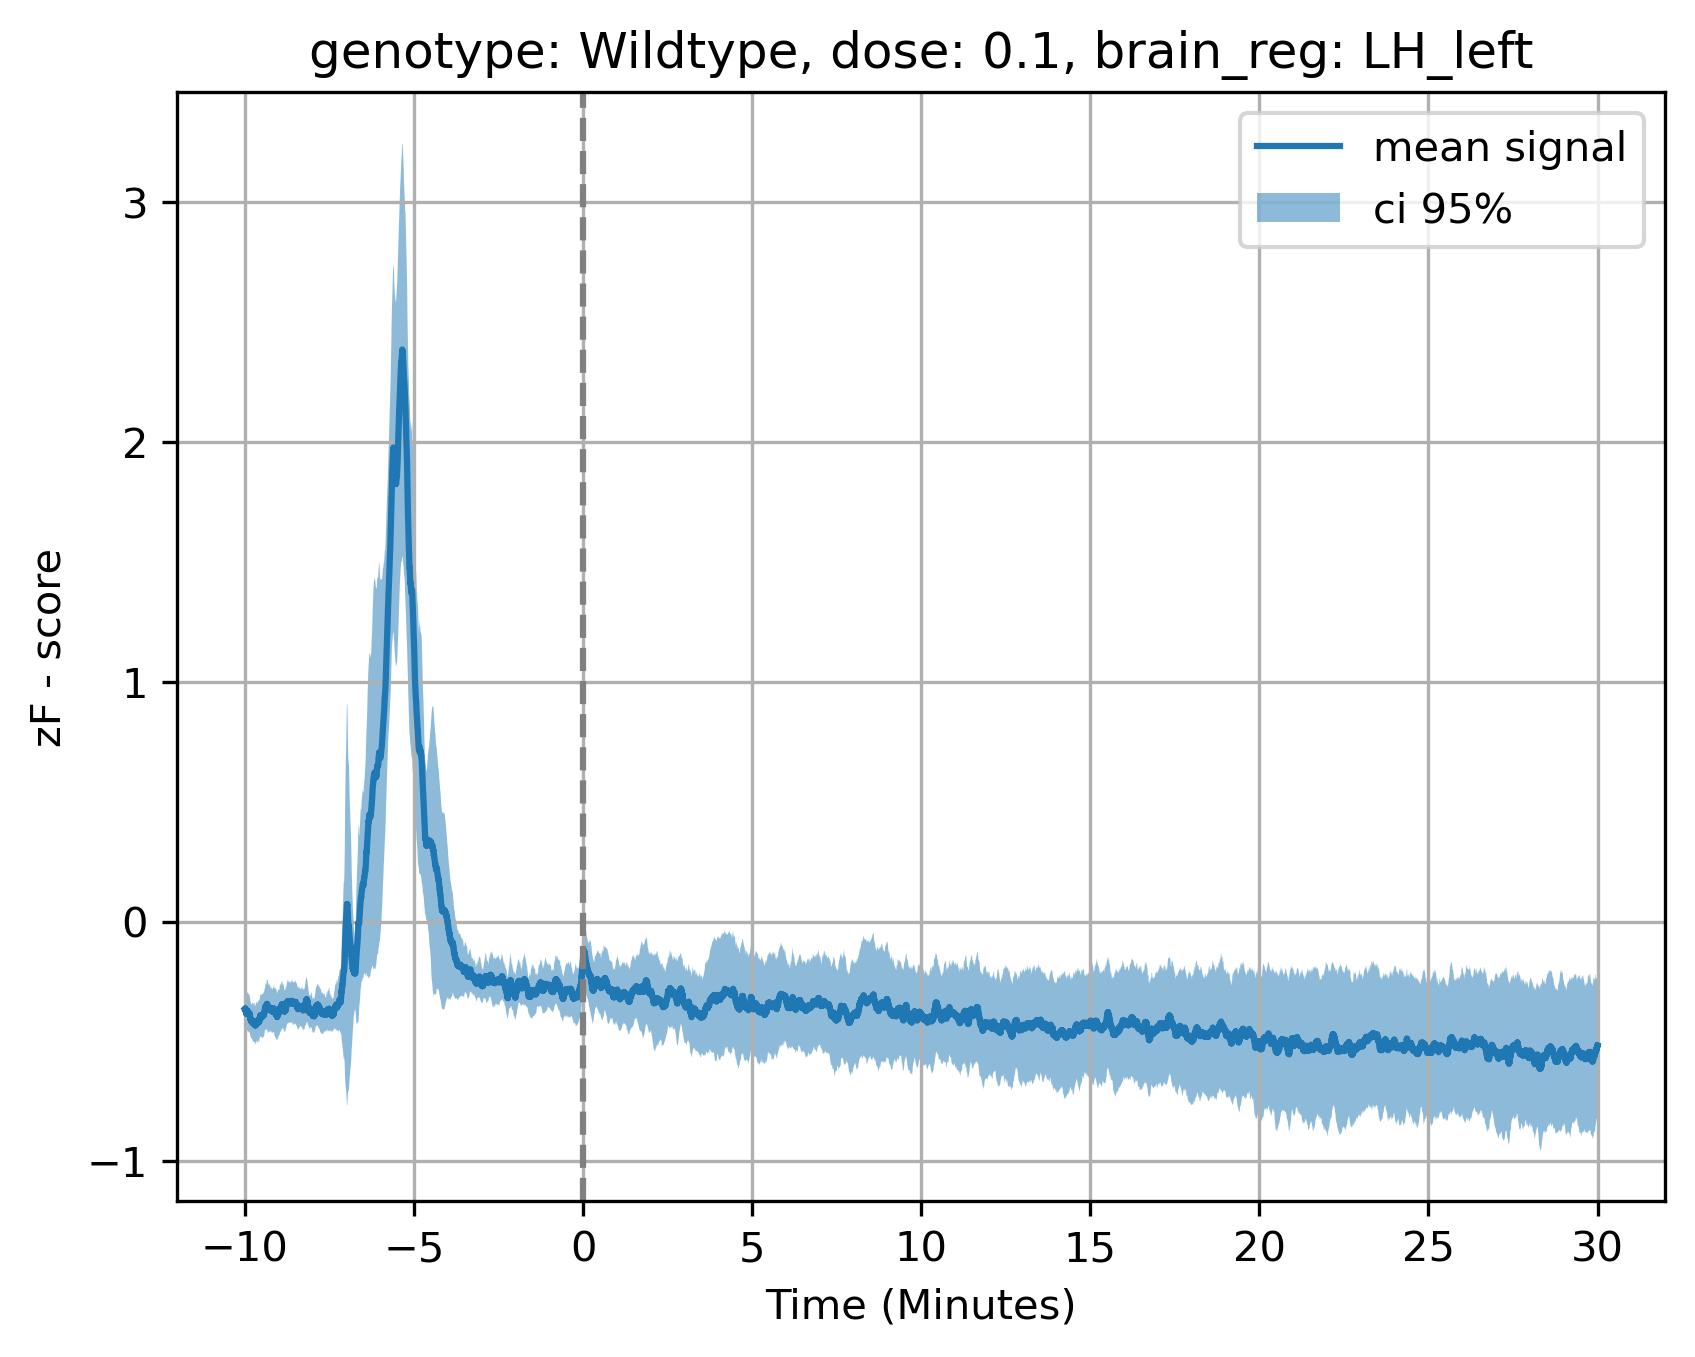

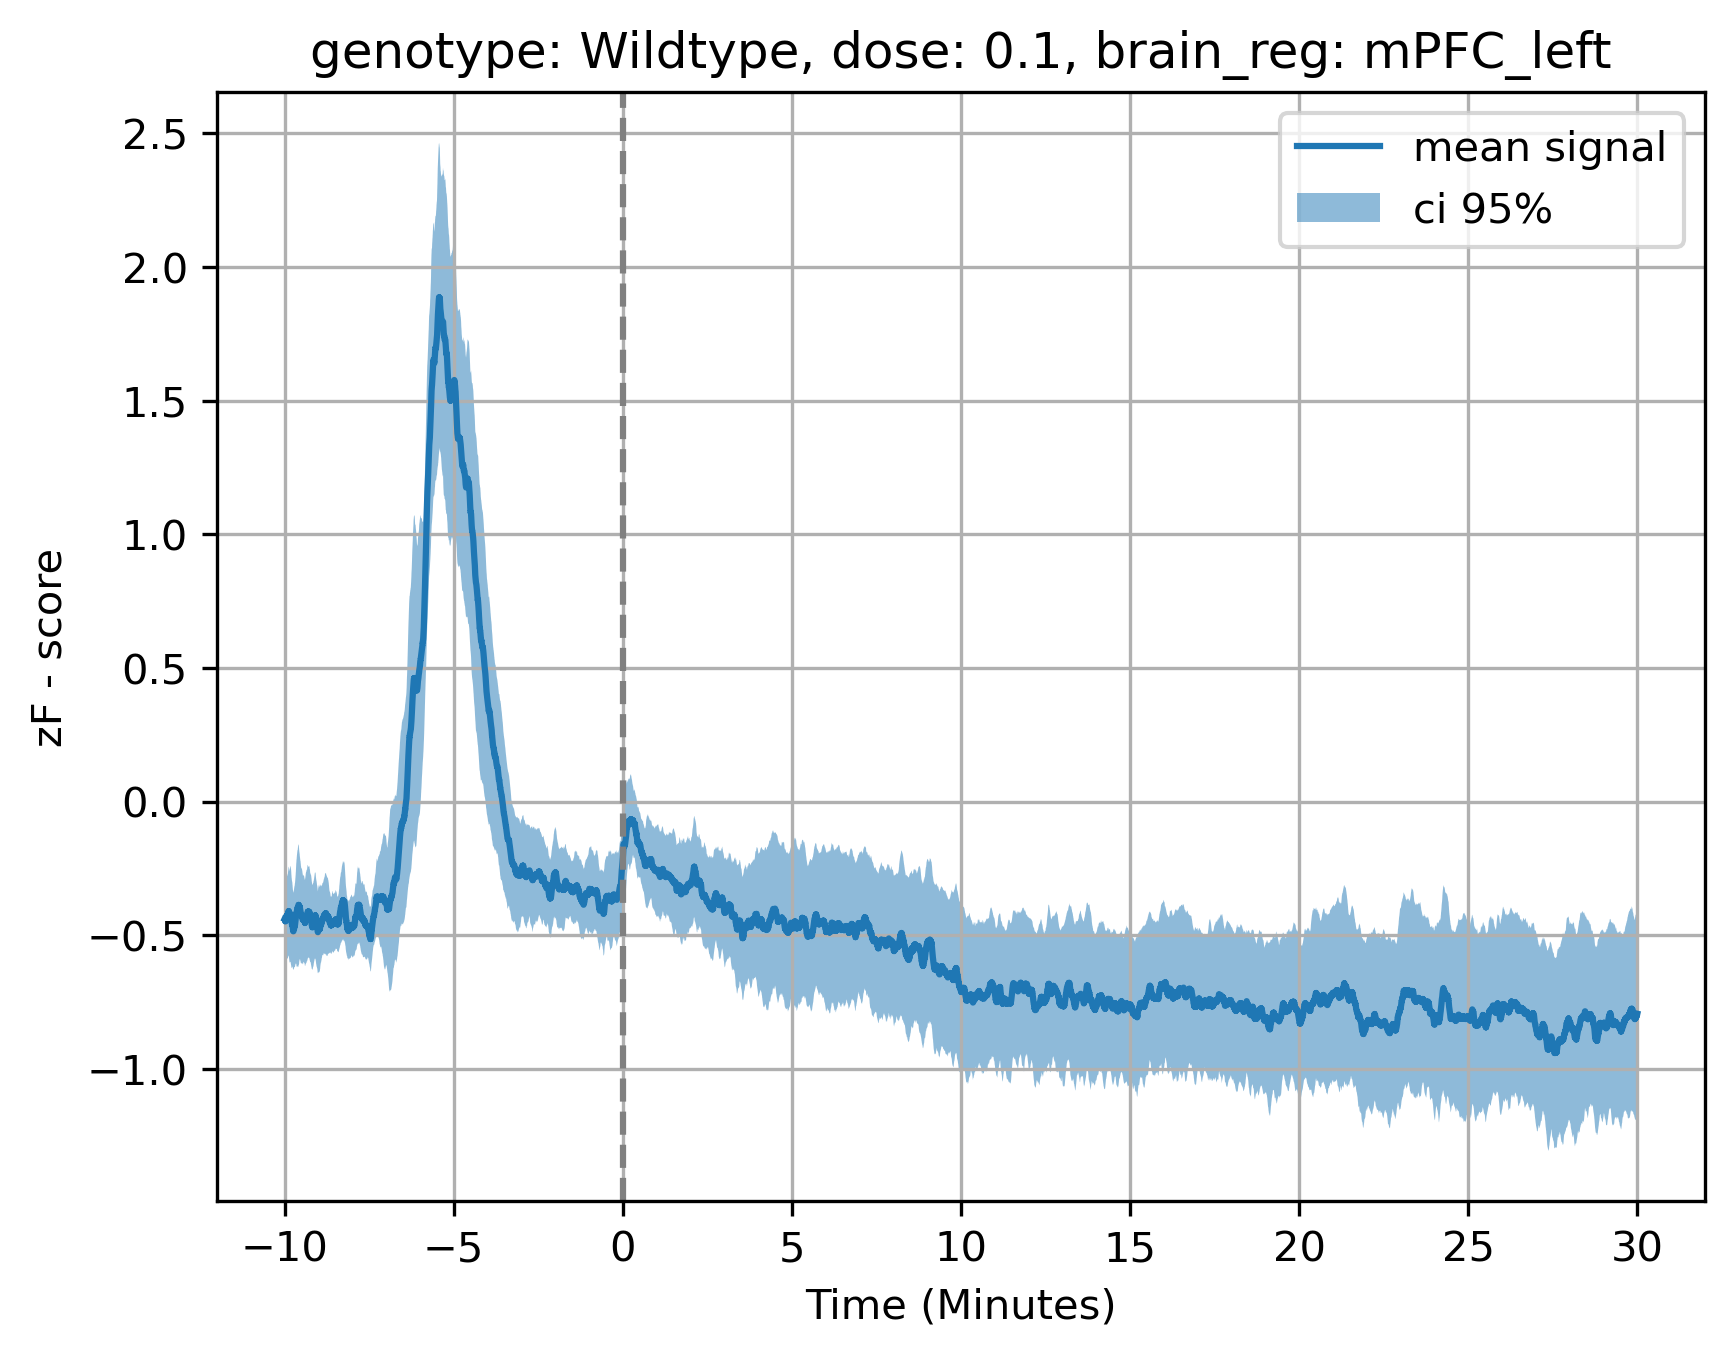

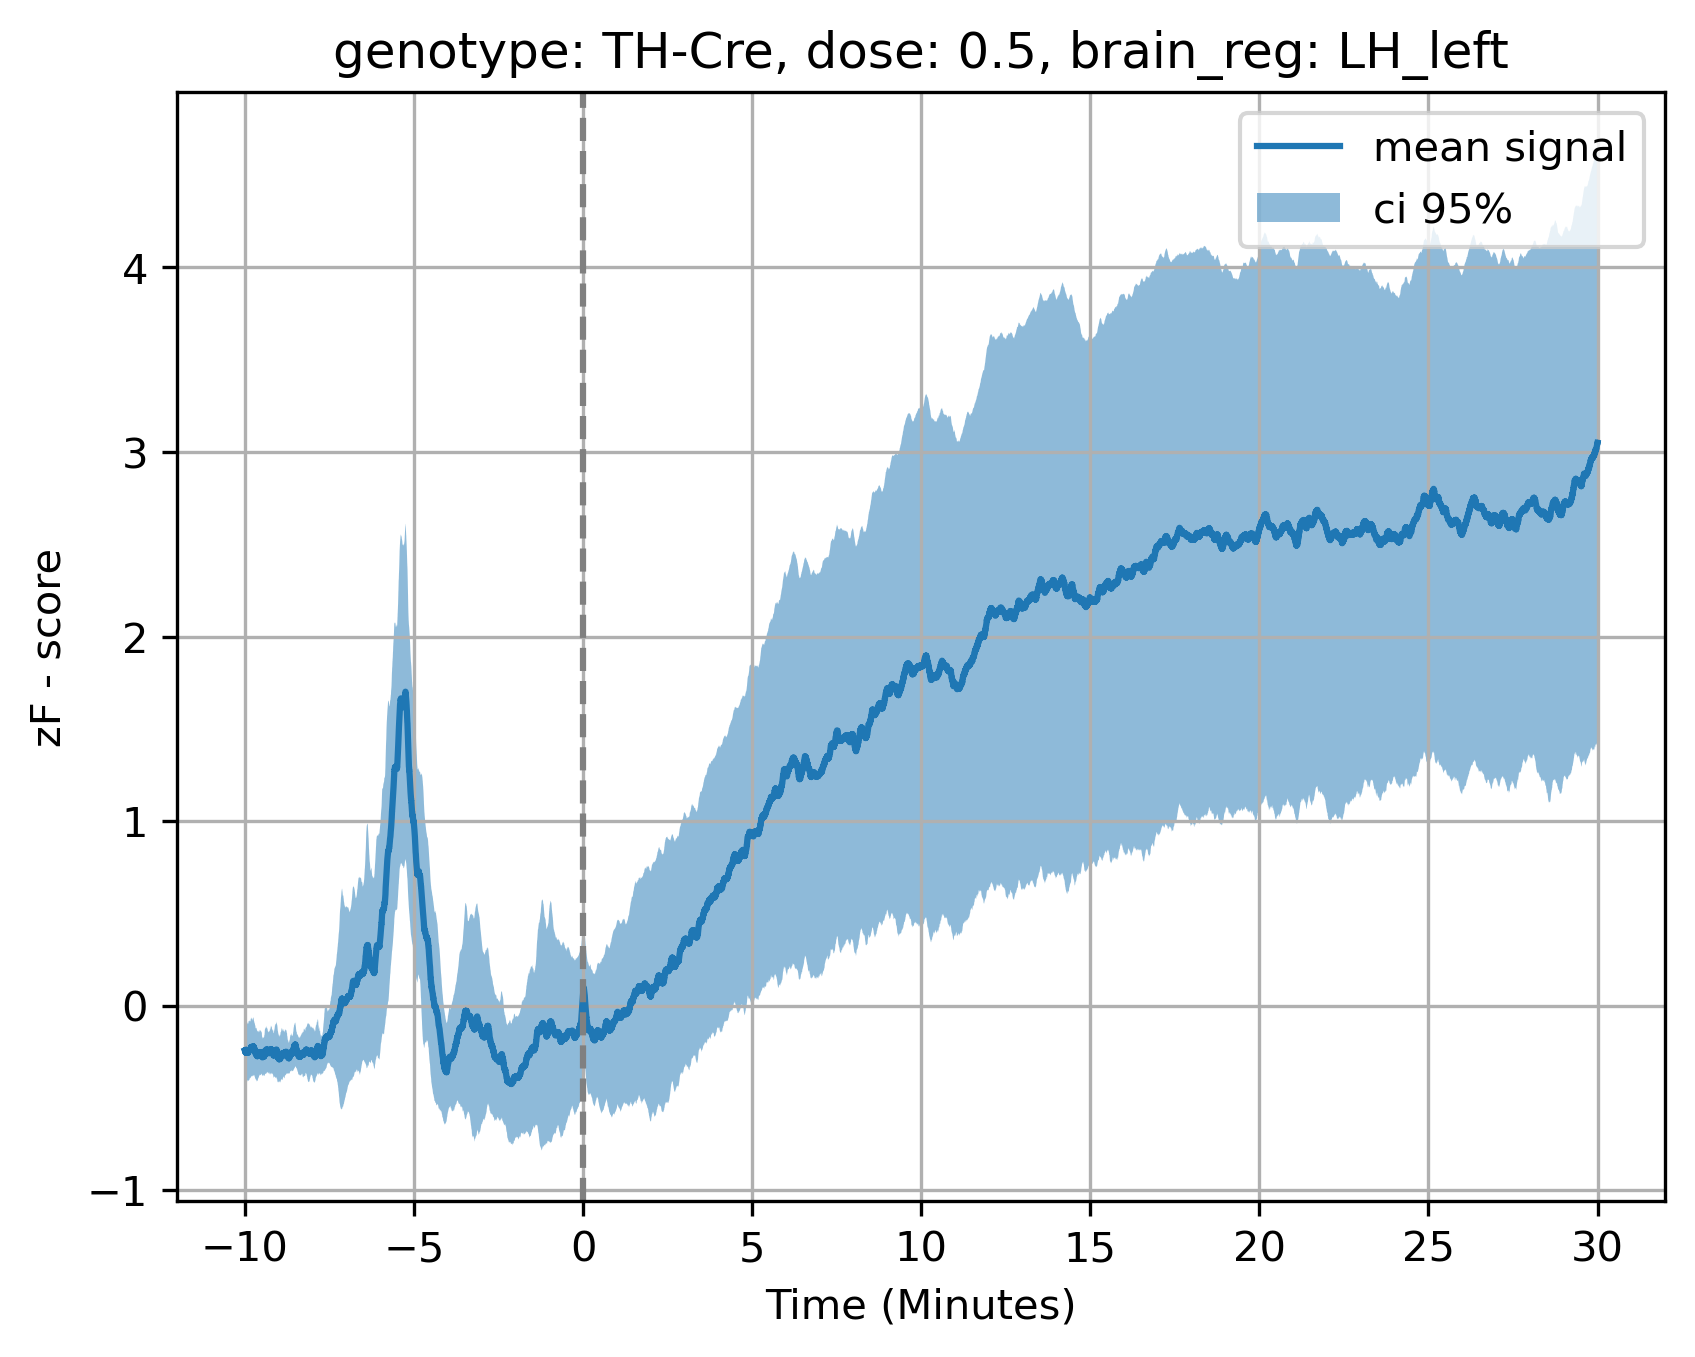

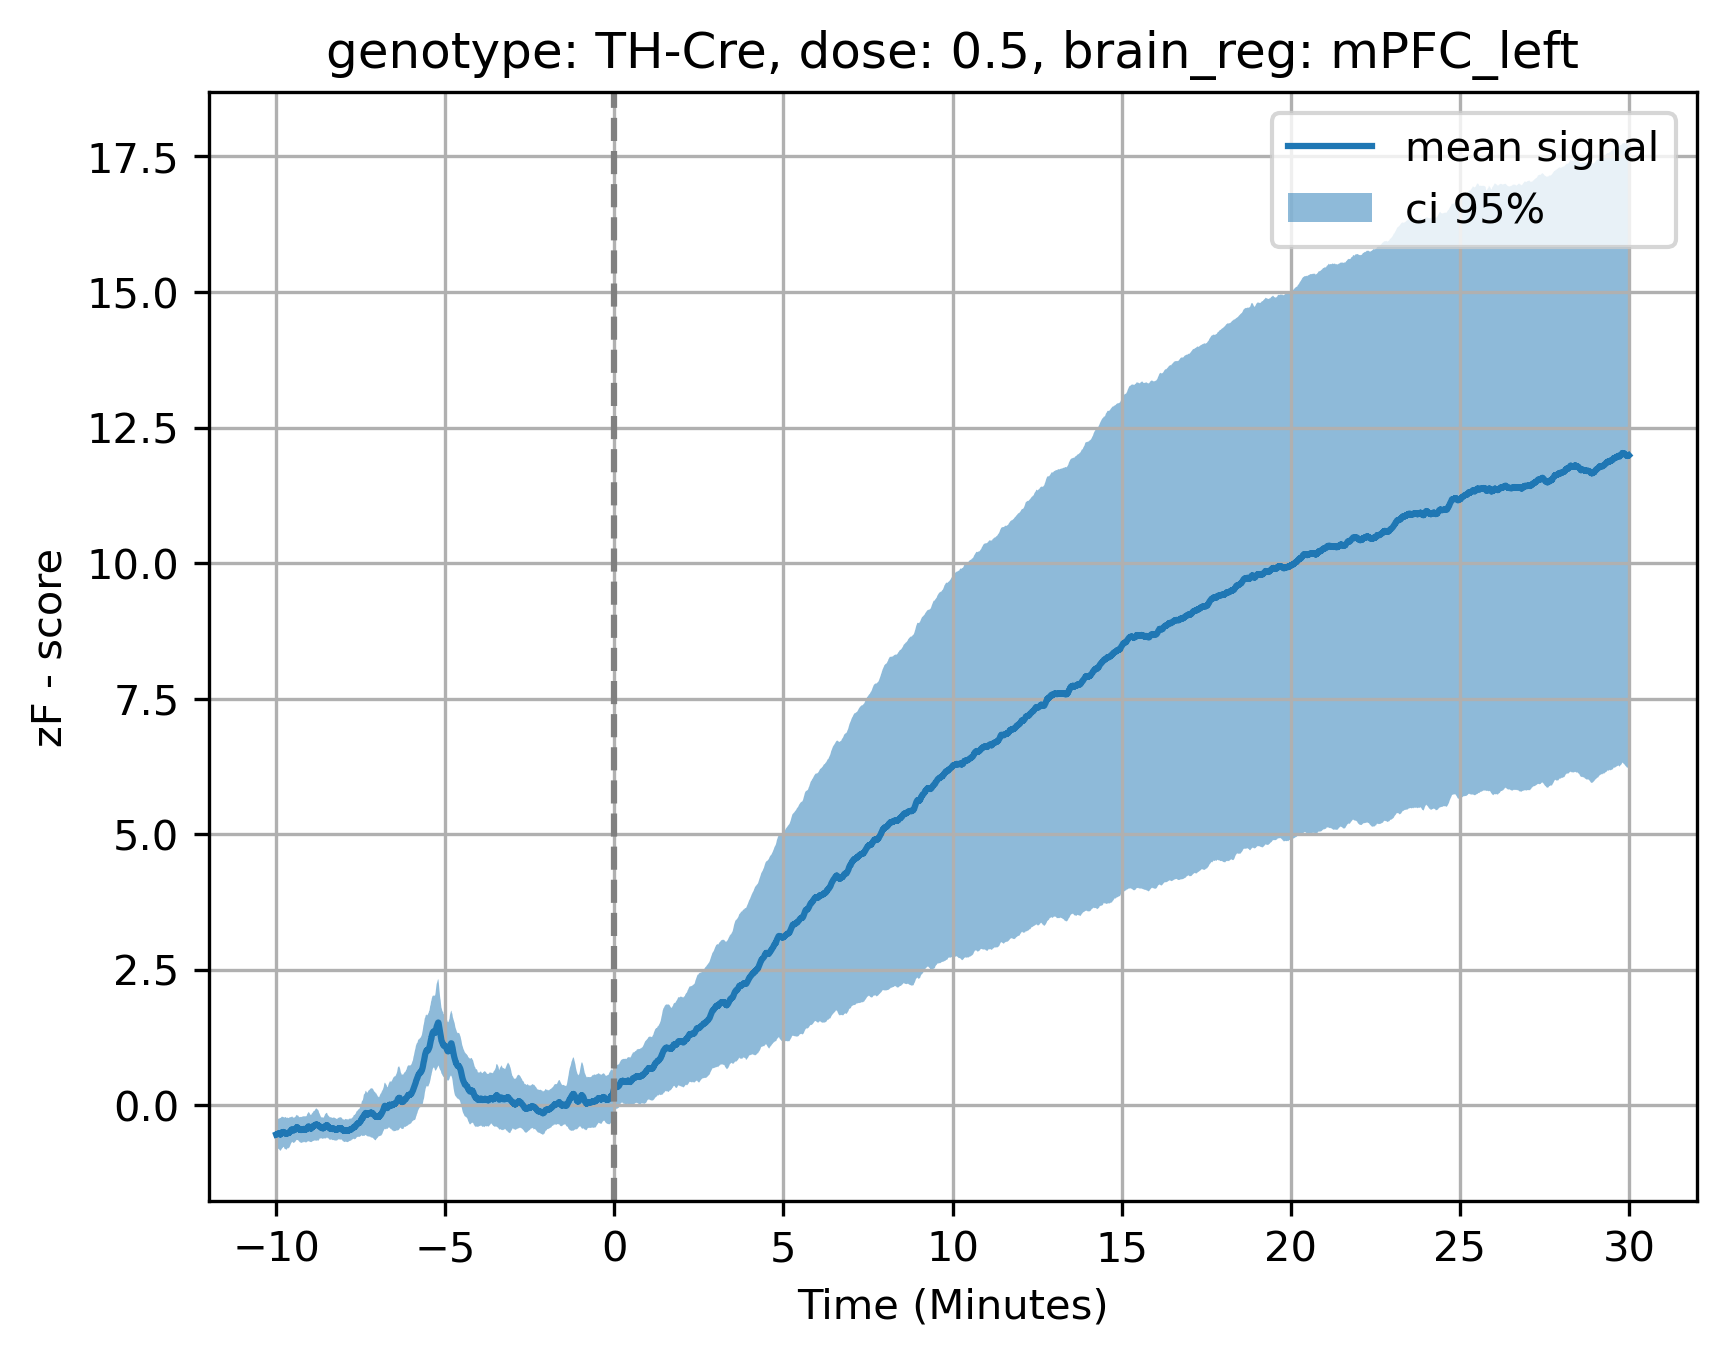

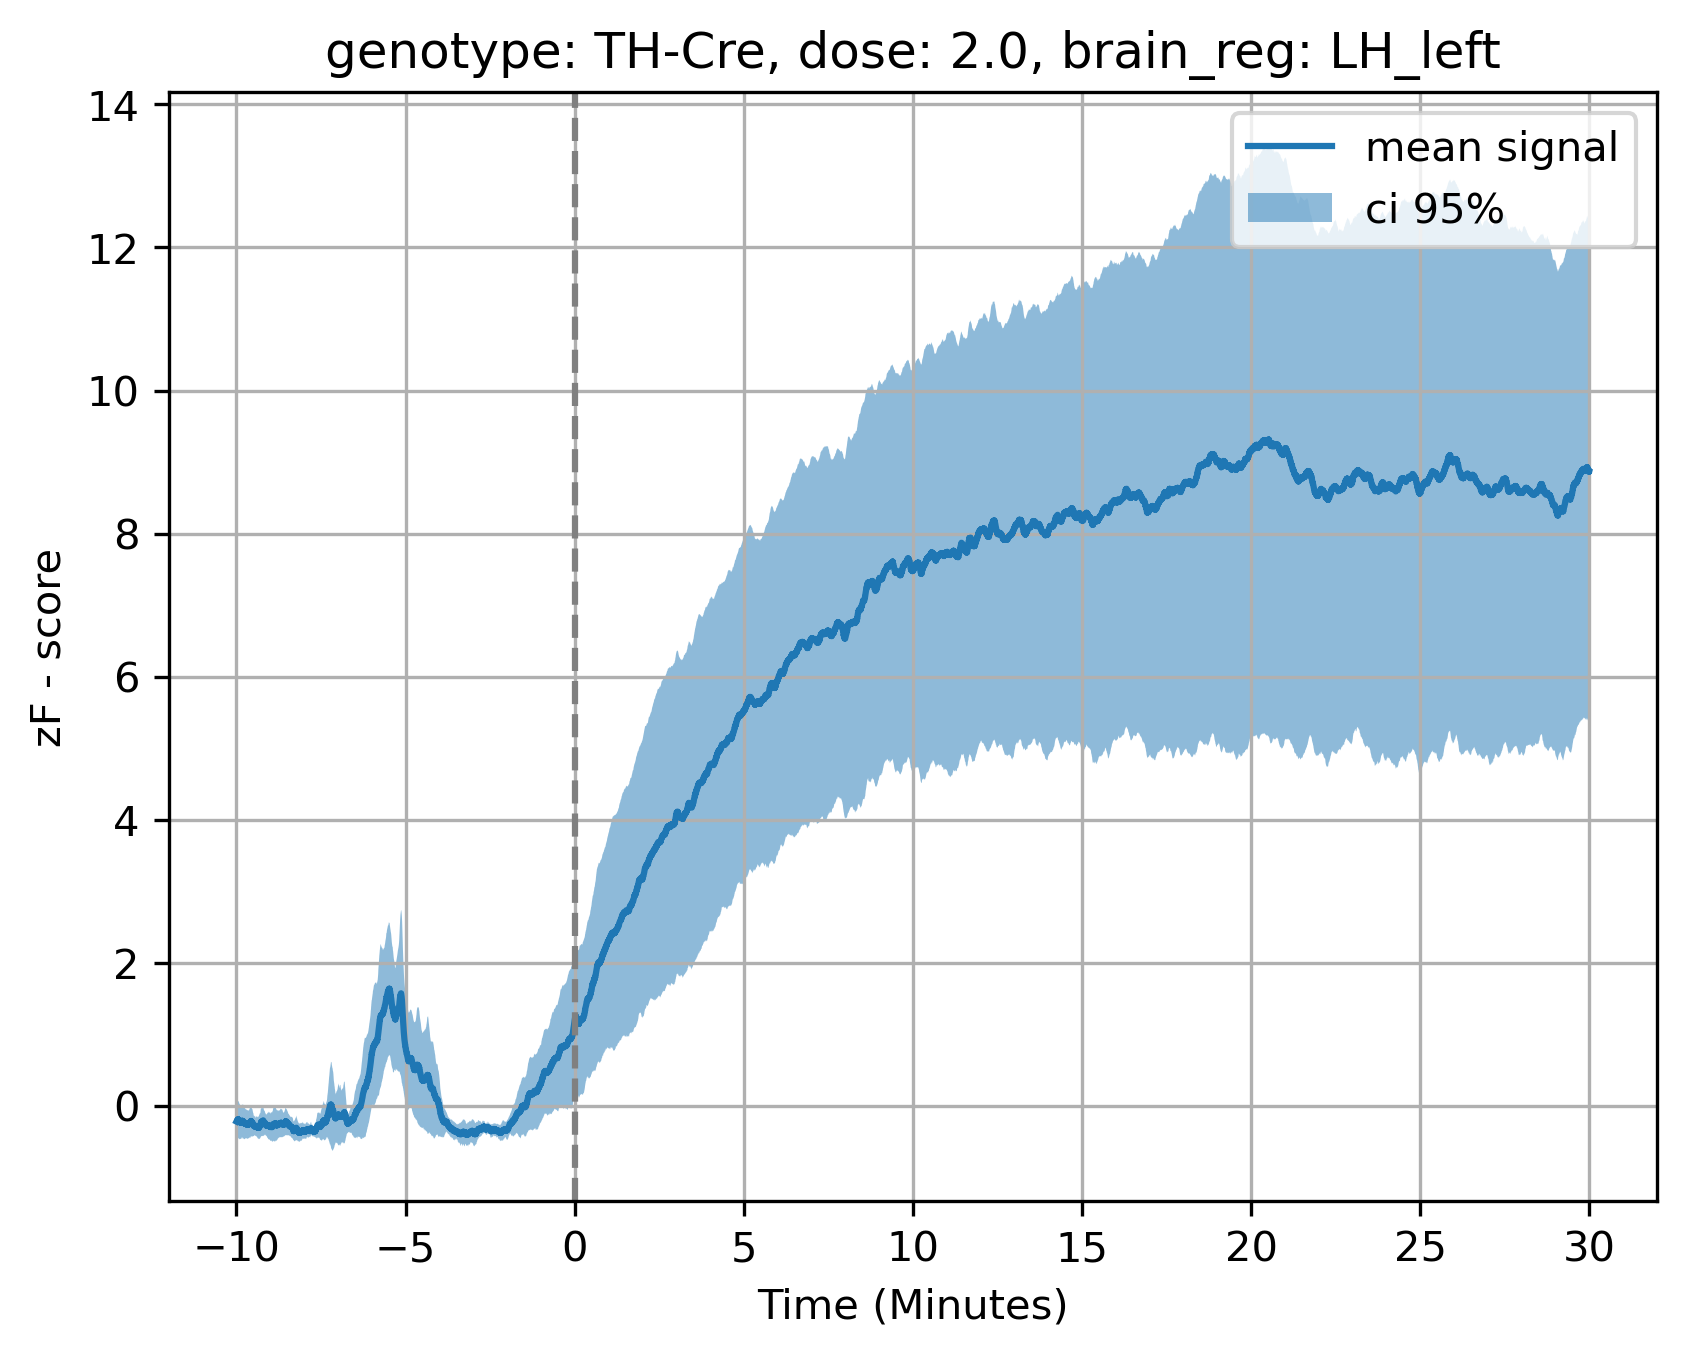

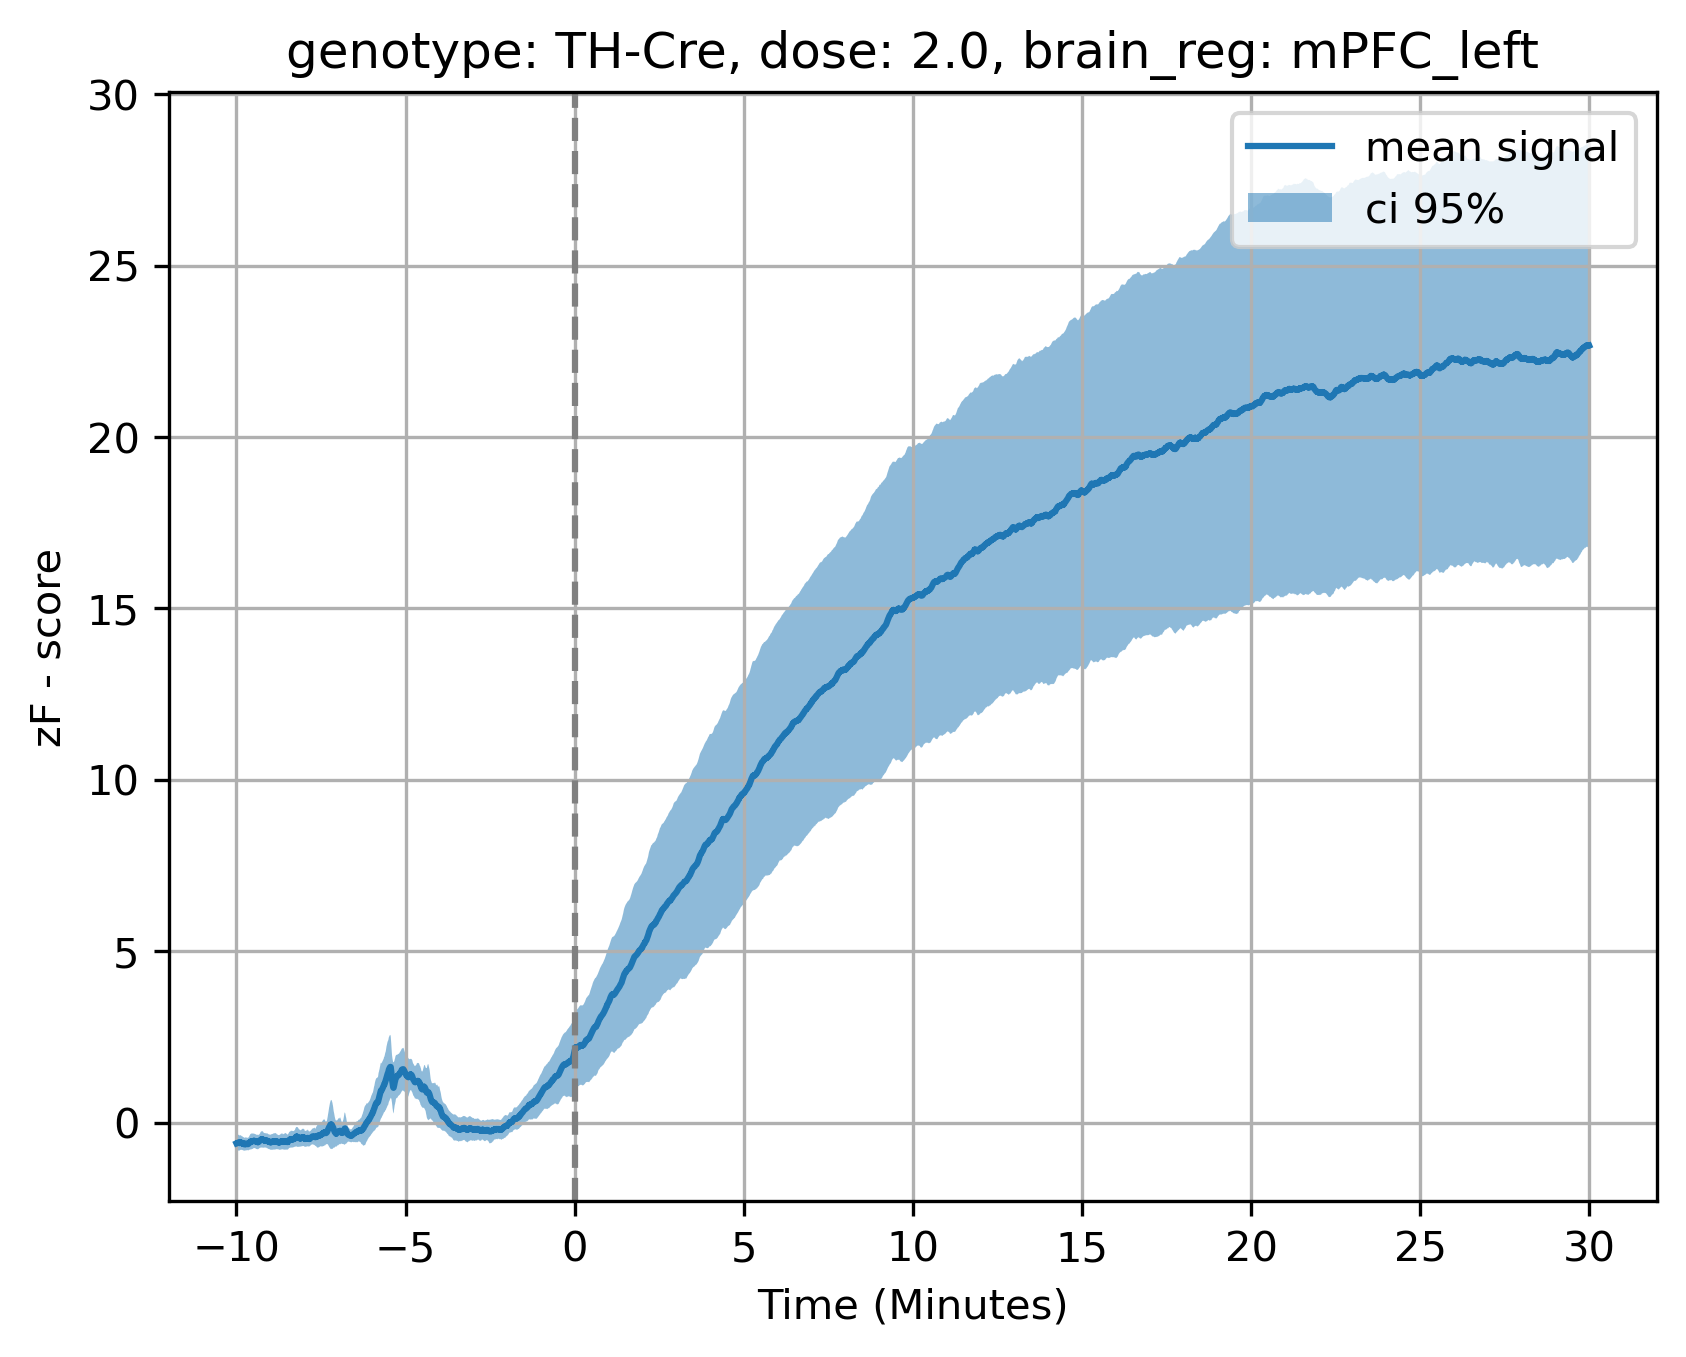

In [9]:
def smooth_signal(signal, window_len=11):
    window = np.ones(window_len) / window_len
    return np.convolve(signal, window, mode='valid')


# Parameters
start_time = -10  # Start time in arbitrary units
end_time = 30  # End time in arbitrary units
smoothing_window = 101  # Smoothing window length

for curr_key, data in all_signal_groups.items():
    # Apply smoothing to the data
    smoothed_data = np.apply_along_axis(smooth_signal, 1, data, window_len=smoothing_window)
    
    # Calculate the mean and standard error of the mean (SEM) across the first dimension
    mean_signal = np.mean(smoothed_data, axis=0)
    sem_signal = np.std(smoothed_data, axis=0) / np.sqrt(smoothed_data.shape[0])
    
    # Calculate the 95% confidence interval
    ci_95 = 1.96 * sem_signal
    
    # Generate x-axis values
    x_values = np.linspace(start_time, end_time, mean_signal.shape[0])
    
    # Plot the data with fill between for 95% CI
    genotype, dose, brain_reg = curr_key

    plt.figure(dpi=300)
    plt.plot(x_values, mean_signal, label='mean signal')
    plt.fill_between(x_values, mean_signal - ci_95, mean_signal + ci_95, alpha=0.5, label='ci 95%')
    plt.axvline(x=0, color='grey', linestyle='--')
    plt.title(f'genotype: {genotype}, dose: {dose}, brain_reg: {brain_reg}')
    plt.xlabel('Time (Minutes)')
    plt.ylabel('zF - score') 
    plt.legend()
    plt.grid()

    plt.savefig(f'{genotype}_{dose}_{brain_reg}_session_mean_CPT.png')
    plt.show()

In [5]:
import matplotlib.pyplot as plt

In [6]:
# brain_reg_to_color = {'VS': 'purple',
#                       'DMS': 'forestgreen',
#                       'DLS': 'C0'}

brain_reg_to_color = {'LH': 'orange',
                      'mPFC': 'cornflowerblue'}

In [7]:
import pickle

with open('all_signals_1.pickle', 'rb') as file:
    # Load the data back into a Python object
    all_signals_1 = pickle.load(file)

with open('all_signals_2.pickle', 'rb') as file:
    # Load the data back into a Python object
    all_signals_2 = pickle.load(file)

FileNotFoundError: [Errno 2] No such file or directory: 'all_signals_1.pickle'

In [ ]:
all_signals_1[('hit', 'LH')].shape

In [ ]:
all_signals = {}

for k in all_signals_1.keys():
    all_signals[k] = np.vstack([all_signals_1[k], all_signals_2[k]])

In [ ]:
def preprocess_and_plot_signals(sessions, event_type, brain_region, smoothing_len=10):
    # Assuming all_signals is predefined
    signals = all_signals[(event_type, brain_region)]

    interval_start = config.peak_interval_config["interval_start"]
    interval_end = config.peak_interval_config["interval_end"]
    fps = config.PLOTTING_CONFIG['fps']
    
    xs = np.arange(-interval_start, interval_end) / fps
    
    # Smooth the mean signal
    ys = np.mean(signals, axis=0)
    window = np.ones(smoothing_len) / smoothing_len
    ys = np.convolve(ys, window, 'same')

    # Calculate the standard deviation of the mean
    std_signal = np.std(signals, axis=0) / np.sqrt(len(signals))

    # Use scipy.stats.norm.interval to get the 95% confidence interval
    alpha = 0.95
    ci_lower, ci_upper = stats.norm.interval(alpha, loc=ys, scale=std_signal)

    # The lower and upper bounds
    lb = ci_lower.min()
    ub = ci_upper.max()

    ylim = (lb, ub)
    
    # Assuming brain_reg_to_color is predefined
    color = brain_reg_to_color[brain_region]

    plt.figure(dpi=300)
    plt.plot(xs, ys, color=color, label='Mean Signal')
    plt.fill_between(xs, ci_lower, ci_upper, color=color, alpha=0.2, label='95% CI')
    plt.ylim(ylim)
    plt.title(f'{event_type}, {brain_region}, (n = {len(signals)})')
    plt.xlabel('Time (s)')
    plt.ylabel('z-score')
    plt.legend()
    plt.grid()
    plt.show()

    # Save the figure locally
    # filename = f'leonie_fig_{event_type}_{brain_region}.png'
    # plt.savefig(filename)
    # plt.show()

# Example usage
# Assuming sessions, config, all_signals, brain_reg_to_color are defined
for event_type, brain_reg in product(config.all_event_types, config.all_brain_regions):
    preprocess_and_plot_signals(sessions, event_type, brain_reg)

In [ ]:
import pickle

with open('all_signals_2.pickle', 'wb') as file:
    # Pickle the dictionary and write it to the file
    pickle.dump(all_signals, file)